# 1. Preparation

### 1.1 Packages, Dates, & Initials

In [79]:
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from labellines import labelLine, labelLines

#administrative packages
import os
import datetime
mydate = datetime.datetime.now()
from datetime import date,timedelta
import time
start = time.time()

#standard packages
import pandas as pd
import numpy as np
import math

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
#from labellines import labelLine, labelLines

#administrative packages
import os
import operator
import datetime
mydate = datetime.datetime.now()
from datetime import date,timedelta
import time
start = time.time()
import logging
logger = logging.getLogger('ftpuploader')

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

pd.options.mode.chained_assignment = None

In [80]:
proj_path = 'O:\CDD\PLANNING\GIS\Projects\Permit_Metrics'
os.chdir(proj_path)

holidays = set([
    pd.Timestamp(h) 
    for h in pd.read_excel(r'data\raw_data\City_Holidays.xlsx')['date'].unique()
    ])

In [81]:
planner_initials = {
    'ABC': 'Alan Carreon',
    'AS': 'Ana Spinola',
    'AMS': 'Andrew Smith',
    'CG': 'Chip Griffin',
    'EB': 'Ethan T Bindernagel',
    'GDK': 'Greg Kapovich',
    'GV': 'Gerardo Victoria',
    'HEC': 'Haley E Croffoot',
    'HH': 'Haley Hubbard',
    'JG': 'Jessica J Gonzalez',
    'JCav': 'Jeanine Cavalli',
    'KN': 'Ken Nodder',
    'OA': 'Ozzy Arce',
    'SKG': 'Simar Gill',
    'SP': 'Sukhamrit S Purewal',
    'TC': 'Trishia Caguiat'
}
planner_names = {v:k for k,v in planner_initials.items()}
planner_names['Haley Hubbard'] = 'HEC'
planner_initials['HH'] = 'Haley E Croffoot'

#Complete_Closed = ['Approved - Closed', 'Closed', 'Not Approved - Closed']
#Planner_Closed = ['Close Out', 'Approved', 'Not Approved']
Ent = {
 'Zoning Amendment': 'Amend',
 'Use Permit Minor': 'MUP',
 'Design Review': 'DR',
 'Design Review Oversized Home': 'DR',
 'Design Review Other': 'DR',
 'Design Review Commercial': 'DR',
 'General Plan Amendment': 'Amend',
 'Design Review Antenna': 'DR',
 'Design Review Residential': 'DR',
 'Use Permit Conditional': 'CUP',
 'Use Permit Administrative': 'AUP',
 'ZCL':'ZCL',
 'Variance': 'Vari',
 'Rezoning': 'ReZone',
 'Tree Dripline Encroachment': 'Tree',
 'Tree Removal Permit': 'Tree',
 '': 'Other',
 'Other': 'Other',
 'Tentative Map Major Subdivision': 'Maj Sub',
 'Drip Line Encroachment': 'Other',
 'Tentative Map Minor Subdivision': 'Min Sub',
 'Tentative Map Condo Conversion': 'Conv',
 'Hillside Performance Standards': 'Other'}
Ent_names = {v:k for k,v in Ent.items()}
Ent_names['Other'] = 'Other'

### 1.2 Finding Type

In [82]:
file_name = 'PermitMetrics_Planning.csv'
tit = 'Planning'

In [83]:
BUILD = {
    'Application Submittal - Route':'Start',
    'Consolidated Comments - With Customer for Response':'Round_End',
    'Resubmittal or Revision - Route':'Round_Start',
    #'Building Review - Notes':'Pause',
    'Ready to Issue - Conditionally Approved':'End',
    'Ready to Issue - Issued':'End',
    'Ready to Issue - Approved':'End'
}

SDP = {
    'Status - Received':'Start',
    'Application Submittal - Route':'Start',
    'Consolidated Comments - With Customer for Response':'Round_End',
    'Consolidated Comments - Resubmittal':'Round_Start',
    #'Consolidated Comments - Ready to Issue': 'Round_Start',
    #'Status - Approved':'End'
    'Ready to Issue - Issue':'End'
    #'Application Submittal - Ready to Issue':'End'
}

PLAN_30 = {
    'Status - Received':'Start',
    'Intake Review - Application Accepted':'Start',
    'Consolidated Comments - Deemed Incomplete':'Round_End',
    'Resubmittal - Route for Review':'Round_Start',
    'Consolidated Comments - Deemed Complete':'End',
    'Staff Analysis - Set for Hearing':'End',
    'Staff Analysis - Staff Level Decision':'End'
}

index = 'Application #'
index_col = index
sum_columns = [
    'Total Days', 'Total Business Days', 'City Business Days', 'Rounds', 'Days till Routing'
]
date_columns = [
    'Days per Round', 
    'Submittal Date', 
    'Final Date'
]
keep_fields = [index] + sum_columns + date_columns


if 'Planning' in tit:
    #sorts = ['Date Status']
    dept = 'Planning'
elif ('Commercial' in tit)or('Residential' in tit)or('Construction' in tit):
    dept = 'Building'
elif 'Site Development Permit' in tit:
    dept = 'Engineering'

local_folder = proj_path
#local_folder = r'C:\Users\nelms\Dropbox\Python\WC'

os.chdir(local_folder)
file_path = os.path.join(os.getcwd(), 'data', 'raw_data', file_name)

stat_d = PLAN_30

less, great = ('2017Q4', '2023Q1')
less, great = ((pd.to_datetime(less)).to_period('Q'), (pd.to_datetime(great)).to_period('Q'))

# 2. Preparing Admin & Count Dataframes

### 2.1 Core Format Functions

In [84]:
sorts = ['Date Status', 'Updated Date', 'Date Assigned']

def sum_days(strt, nd, business_days=True):
    if business_days == True:
        days = [d for d in pd.bdate_range(start=strt, end=nd).to_list() if d not in holidays]
    if business_days == False:
        days = pd.date_range(start=strt, end=nd).to_list()
    return days

def make_dates(permit_df):
    # turns date columns into datetime format
    date_cols = [tt for tt in list(permit_df) if ('Date ' in tt)or(' Date' in tt)]
    permit_df[date_cols] = permit_df[date_cols].apply(pd.to_datetime)
    return permit_df

def prepare_times(raw_permit_df, extra_list=[]):
    #'APN', 'DESCRIPTION', 'Address'
    n=0
    ## check if Accela added a title/description in the first row
    raw_permit_df = raw_permit_df
    if 'P_ID' not in list(raw_permit_df):
        raw_permit_df = pd.read_csv(file_path, skiprows=0)
    
    raw_permit_df.rename(columns={'P_ID':'Application #'}, inplace=True)
    
    # turns date columns into datetime format
    raw_permit_df = make_dates(raw_permit_df)
    
    # check date columns for tracking date
    #if 'Date Status' not in date_cols:
    #    raw_permit_df['Date Status'] = raw_permit_df['Updated Date']
    
    # The main column of tracking
    raw_permit_df['Task Status'] = raw_permit_df['Task'] + ' - ' + raw_permit_df['Status']
    
    raw_admin_df = raw_permit_df.copy()
    
    raw_fields = ['Application #', 'Permit Type', 'Record Status']    
    
    raw_fields.extend([
        c for c in extra_list 
            if c in list(raw_admin_df) or 
            c.title() in list(raw_admin_df) or 
            c.upper() in list(raw_admin_df)
    ])

    #raw_admin_df = raw_admin_df[raw_fields].drop_duplicates().set_index('Application #')
    raw_admin_df = raw_admin_df \
        [[c for c in raw_admin_df 
            if 'Date' not in c or 
            c not in [
                'Task Status', 'Task', 'Status', 'E_ID'
            ]
            ]] \
        .drop_duplicates(subset=['Application #', 'Permit Type', 'Record Status']) \
        .set_index('Application #')
    
    # Fields of Focus
    raw_permit_df = raw_permit_df[[
        'Application #', 'Task Status', 'Date Assigned', 'Date Status', 'Updated Date']]
    
    # only selects if the record is in our time period and in our focus Task Statuses
    #raw_permit_df_endfinder = raw_permit_df[raw_permit_df['Task Status'].isin(stat_d.keys())].copy()
    #ends_after_Q = set(raw_permit_df_endfinder.loc[(raw_permit_df_endfinder['Updated Date'].dt.to_period('Q')>less), 'Application #'].values)
    #raw_permit_df = raw_permit_df[raw_permit_df['Application #'].isin(ends_after_Q)]
    
    raw_permit_df = raw_permit_df.rename(columns={'Application #':'#'})
    raw_permit_df = raw_permit_df.set_index(['#', 'Task Status'])
    # sort by when the statuses were updated
    raw_permit_df.sort_values(by=['#']+sorts, inplace=True)
 
    old_idx = raw_permit_df.index.names
    raw_permit_df = raw_permit_df \
        .reset_index() \
        .dropna(axis=0, subset=['#','Task Status']) \
        .set_index(old_idx)
    
    # For Planning Applications, allow received date
    if 'Status - Received' in raw_permit_df.index.get_level_values(1):
        
        raw_permit_df.reset_index(inplace=True)
        focus = set(raw_permit_df[raw_permit_df['Task Status'].isin(['Status - Assigned', 'Status - Received'])].index)
        #IDs = {i:[] for i in focus}
        #[IDs[i].append(ts) for i in focus]
        #IDs = [k for k,v in IDs.items() if len(v) > 1]
        
        #for x in focus:
        #    raw_permit_df.loc[x, 'Date Assigned'] = raw_permit_df.loc[x, 'Date Status']
        #    raw_permit_df.loc[x, 'Date Status'] = raw_permit_df.loc[x, 'Updated Date']

        raw_permit_df.set_index(['#', 'Task Status'], inplace=True)
        
    return raw_permit_df, raw_admin_df

### 2.1.1 First Clean

In [85]:
def first_clean(permit_df):

    permit_df = (
            permit_df
                .drop_duplicates(
                    subset=['P_ID', 'Permit Type', 'Task', 'Status', 'Date Status'], 
                    keep='first'
                )
                )
    return permit_df

### 2.2 Accessory Prep Functions

#### 2.2.1 Entitlements

In [86]:
# FIX MASTER SIGN PERIT
def fix_msp(row):
    ptype = row['Permit Type']
    pdesc = row['Description']

    msps = ['msp', 'msps', 'sign', 'signs']

    for dword in pdesc.split(' '): 
        dword = dword.lower()
        if dword in msps:
            return 'Design Review Sign'
    return pdesc

# FIX ENTITLEMENTS
type_fix = {
        'ZCL':['ZCL', 'Zoning Compliance'],
        'Design Review Sign':['MSP', 'SIGN', 'SIGNS', 'Sign', 'Signs', 'msp', 'MSPA', 'rebranding'],
        'PRE APP':['PRE APP', 'Pre-App', 'PRE-APP'],
        'Reasonable Accomodation':['Reasonable Accomodation'],
        'SUP':['Special Use Permit'],
        'LFDCH':['LFDCH']
    }
def fix_ents(
        test_df,
        type_fix=type_fix
        ):
    
    col_search = ['Description', 'Notes']
    type_col = 'Permit Type'
    other_values = 'Other'
    replace_col = 'Permit Type'

    test_df[[type_col]+col_search] = test_df[[type_col]+col_search].astype(str).fillna('')

    for tkey, tvalues in type_fix.items():
        for tvalue in tvalues:
            for focus_col in col_search:
                temp_filt = (test_df[type_col].str.contains(other_values))&(test_df[focus_col].str.contains(tvalue))
                if len(test_df[temp_filt]) > 0:
                    test_df.loc[temp_filt, replace_col] = tkey
    return test_df

ent_cols = ['Entitlements', 'Num of Entitlements']
nicknames = {
        'Design Review':'DR',
        'Use Permit':'UP',
        'Administrative':'Admin',
        'Residential':"Resi",
        'Commercial':'Comm'
    }
def group_entitlments(
        raw_permit_dataframe, 
        ent_cols = ent_cols,
        nicknames = nicknames):
    

    def clean_ent(ents):
        clean_ents = list(set(ents))
        return clean_ents
    def ent_agg(ents):
        lents = []
        
        for item in clean_ent(ents):
            item = str(item)
            for nick in nicknames.keys():
                if nick in item:
                    item = item.replace(nick, nicknames[nick])
            lents.append(item)
        lents.sort()

        sents = ', '.join([str(i) for i in lents])
        if len(lents) == 1:
            sents = sents.strip('*')
        return sents
    def ent_count(ents):
        return len(clean_ent(ents))

    group_permits = raw_permit_dataframe.copy()
    group_permits.loc[group_permits['Primary']=='Yes', 'Permit Type'] = '*' + group_permits['Permit Type'].astype(str)

    group_permits = group_permits.groupby('P_ID').agg({
        'Permit Type':[ent_agg, ent_count]
    })

    group_permits.columns = group_permits.columns.droplevel()
    group_permits.columns = ent_cols

    return raw_permit_dataframe.join(group_permits, on='P_ID')

#### 2.2.2 Decision & Intake

In [87]:
hearing_tasks = ['City Council', 'Planning Commission', 'Design Review Commission', 'Zoning Administrator']
def get_decisions(raw_permit_df):
    staff_tasks = ['Staff Level Decision']

    raw_permit_df['Staff Decision'] = 'False'
    staff_filt = raw_permit_df['Task'].isin(staff_tasks)
    raw_permit_df.loc[staff_filt, 'Staff Decision'] = 'True'
    staff_ids = raw_permit_df.loc[staff_filt, 'P_ID'].unique()
    raw_permit_df.loc[raw_permit_df['P_ID'].isin(staff_ids), 'Staff Decision'] = 'True'

    raw_permit_df['Board Decision'] = 'False'
    board_filt = raw_permit_df['Task'].isin(hearing_tasks)
    raw_permit_df.loc[board_filt, 'Board Decision'] = 'True'
    board_ids = raw_permit_df.loc[board_filt, 'P_ID'].unique()
    raw_permit_df.loc[raw_permit_df['P_ID'].isin(board_ids), 'Board Decision'] = 'True'

    raw_permit_df.loc[raw_permit_df['Board Decision']=='True', 'Staff Decision'] = 'False'

    return raw_permit_df

def get_planner(permit_df, planner_cols = ['Planner F', 'Planner L']):
    def combine_str(x):
        l = [i for i in list(x) if i!='']
        d = ', '.join(list(dict.fromkeys(l)))
        return d

    def group_permit_df_by_planner_count(permit_df, planner_cols = ['Planner F', 'Planner L']):
        grp = permit_df.groupby(['P_ID', planner_cols]) \
            .agg({'Primary':len}) \
            .rename(columns = {'Primary':'Row Count'}) \
            .reset_index() \
            .sort_values('Row Count', ascending=False)
        grp['Planner'] = grp['Planner'].fillna('')
        grp = grp.groupby('P_ID') \
            .agg({'Planner':combine_str})
        return grp['Planner'].to_dict()

    test_dict = group_permit_df_by_planner_count(permit_df, planner_cols = planner_cols)

    permit_df['Planner'] = permit_df['P_ID'].map(test_dict)

    permit_df['Planner'].value_counts()

    return permit_df


In [88]:
def add_list_to_dict(old_dict, new_list, fill=False):
    new_dict = old_dict.copy()
    for i in new_list:
        if i not in new_dict.keys():
            if fill == False:
                new_dict[i] = i
            else:
                new_dict[i] = fill
    return new_dict

def get_planner(permit_df, planner_col = 'Planner', first_suffix ='F', second_suffix = 'L'):
    p_first_col = planner_col + ' ' + first_suffix
    p_second_col = planner_col + ' ' + second_suffix
    def combine_str(x):
        l = [i for i in list(x) if i!='']
        d = ', '.join(list(dict.fromkeys(l)))
        return d

    def group_permit_df_by_planner_count(permit_df, planner_cols = [p_first_col, p_second_col]):
        grp = permit_df.groupby(['P_ID', planner_cols]) \
            .agg({'Primary':len}) \
            .rename(columns = {'Primary':'Row Count'}) \
            .reset_index() \
            .sort_values('Row Count', ascending=False)
        grp[planner_col] = grp[planner_col].fillna('')
        grp = grp.groupby('P_ID') \
            .agg({planner_col:combine_str})
        return grp[planner_col].to_dict()

    permit_df[planner_col] = ''
    plan_rev_filt = permit_df['Task']=='Planning Review'
    permit_df.loc[plan_rev_filt, planner_col] = permit_df.loc[plan_rev_filt, p_first_col] + ' ' + permit_df.loc[plan_rev_filt, p_second_col]

    def combine_names(x):
        return ', '.join(set(x)).title().strip()

    planner_group = (
        permit_df
            .loc[plan_rev_filt]
            .groupby('P_ID')
            .agg({planner_col:lambda x: combine_names(x)})
            [planner_col]
            .to_dict()
    )
    
    planner_group = add_list_to_dict(
        planner_group,
        permit_df['P_ID'].unique(),
        fill=''
    )
    
    permit_df[planner_col] = permit_df['P_ID'].map(planner_group)
    
    df_cols = [
        planner_col if col == p_first_col 
        else col
        for col in permit_df.columns.tolist()
        if col not in [planner_col, p_second_col]
        ]

    return permit_df[df_cols]

#### 2.2.3 Board Info & Days

In [89]:
def get_board_info(raw_permit_df):
    hearing_dict = {
        'Planning Commission' : 'PC',
        'Design Review Commission':'DRC',
        'City Council':'CC',
        'Zoning Administrator':'ZA'
    }

    def hearing_list(hearings):
        return [hearing_dict[h] for h in hearings]

    def count_hearings(hearings):
        return len(hearing_list(hearings))

    def string_list(list):
        return ', '.join(list)

    def hearing_string(hearings):
        return string_list(hearing_list(hearings))

    board_df =    raw_permit_df[raw_permit_df['Task'].isin(hearing_tasks)] \
            .drop_duplicates(subset=['P_ID', 'Task']) \
            [['P_ID', 'Task']] \
            .groupby('P_ID') \
            .agg({
                'Task':[hearing_string, count_hearings]
            }) \
            .droplevel(0, axis=1) \
            .rename(columns = {'hearing_string':'Boards','count_hearings':'Board Count'})

    #board_df
    raw_permit_df['Boards']=''
    raw_permit_df['Board Count']=0
    l_dict = board_df['Boards'].to_dict()
    c_dict = board_df['Board Count'].to_dict()

    board_filt = raw_permit_df['P_ID'].isin(c_dict.keys())
    raw_permit_df.loc[board_filt, 'Boards'] = raw_permit_df.loc[board_filt, 'P_ID'].map(l_dict)
    raw_permit_df.loc[board_filt, 'Board Count'] = raw_permit_df.loc[board_filt, 'P_ID'].map(c_dict)

    return raw_permit_df

#### 2.2.4 Address

In [90]:
# make a functional called clean_add_col that takes a column called "Address" and only keep the text before "WALCR"
def clean_add_col(add, splits = ['WALCR', 'WALNUT CREEK']):
    
    splits = list(splits)

    for split in splits:
        if split in add:
            add = add.split(split)[0]
    
    return add.strip().strip(',').strip().upper()

def clean_addresses(permit_df, add_col = 'Address', splits = ['WALCR', 'WALNUT CREEK'], remove_2nd_add = True):

    if add_col in list(permit_df):
        permit_df[add_col] = permit_df[add_col].apply(clean_add_col, splits = splits)

    if remove_2nd_add == True:
        permit_df[add_col] = permit_df[add_col].apply(clean_add_col, splits = [','])

    return permit_df

#clean_addresses(raw_permit_df)['Address'].drop_duplicates().sort_values()

### 2.3 Run Formatting & Prep

In [91]:
raw_permit_df = pd.read_csv(file_path)
raw_permit_df = first_clean(raw_permit_df)
raw_permit_df = fix_ents(pd.read_csv(file_path))
raw_permit_df = group_entitlments(raw_permit_df)
raw_permit_df = get_decisions(raw_permit_df)
raw_permit_df = get_board_info(raw_permit_df)
raw_permit_df = get_planner(raw_permit_df)
raw_permit_df = clean_addresses(raw_permit_df)

prep_permit_df = raw_permit_df[raw_permit_df['Primary']=='Yes']

Formatted_Permits, Admin_Permits = prepare_times(prep_permit_df.copy(), extra_list=ent_cols)

### 2.5 Entitlement Counts

In [92]:
raw_permit_df['Start Year'] = pd.to_datetime(raw_permit_df['Open Date']).dt.year

test_df = raw_permit_df.copy()

test_df['Decision Maker'] = 'Staff'
test_df.loc[test_df['Board Decision']=='True', 'Decision Maker'] = 'Board'

sec_col = 'Decision Maker'
r_melt = test_df \
    [['P_ID', 'Permit Type', sec_col]] \
    .drop_duplicates() \
    [['Permit Type', sec_col]] #\
    #.set_index('Permit Type') #\
    #.melt(var_name='columns', value_name='index')

#pd.crosstab(index=t_melt['index'], columns=t_melt['columns'])
#t_melt.value_counts('Start Year') #.groupby('Permit Type')
bcount_path = r'data\clean_data\board_counts2.csv'
pd.crosstab(index=r_melt['Permit Type'], columns=r_melt[sec_col]).to_csv(bcount_path)

In [93]:
raw_permit_df['Start Year'] = pd.to_datetime(raw_permit_df['Open Date']).dt.year

t_melt = raw_permit_df[['P_ID','Permit Type', 'Start Year']] \
    .drop_duplicates() \
    [['Permit Type', 'Start Year']] #\
    #.set_index('Permit Type') #\
    #.melt(var_name='columns', value_name='index')

#pd.crosstab(index=t_melt['index'], columns=t_melt['columns'])
#t_melt.value_counts('Start Year') #.groupby('Permit Type')
ent_path = r'data\clean_data\entitlement_counts.csv'
pd.crosstab(index=t_melt['Permit Type'], columns=t_melt['Start Year']) \
    .to_csv(ent_path)

# 3. Main Day & Round Processing

#### 3.1 Calculate Days & Rounds Functions

In [94]:
def check_days(srt, ned, a_list, t_list):
    s = [ss for ss in sum_days(srt, ned, business_days=True) if ss not in t_list]
    t_list.update(s)
    a_list.append(len(s))
    return a_list, t_list

def get_rec_list(rec, formatted_permits):
    # Sort by the date & minute they were updated in Accela
    temp = formatted_permits.xs(rec).sort_values(by=sorts).copy()
    # then drop it
    temp.drop('Updated Date', inplace=True, axis=1)
    
    #create 
    temp.index = temp.index.map(stat_d)
    temp.reset_index(inplace=True)
    temp.reset_index(inplace=True)
    temp.rename(columns={'index':index}, inplace=True)
    
    check_fields = ['Task Status', index, 'Date Assigned', 'Date Status']
    ts_df = temp[check_fields].copy()
    ts = temp.loc[~temp['Task Status'].isna()][check_fields].values
    if len(ts) == 0:
        ts = temp.loc[temp[index]==0][check_fields].values     
    return ts_df, ts

def round_check(test_df, test):
    if len(np.where(test[:,0] == 'End')[0]) > 1:
        while len(np.where(test[:,0] == 'End')[0]) > 1:
            false_end = np.where(test[:,0] == 'End')[0][-1]
            test = np.delete(test, false_end, 0)
    elif len(np.where(test[:,0] == 'End')[0]) == 0:
        test[-1,0] = 'End'

    if (len(test) == 1) and (len(test) != len(test_df)): 
        if test[0,1] > 0:
            start_date = pd.to_datetime(test_df.loc[test_df[index] == 0, 'Date Assigned'].values[0])
            route_date = pd.to_datetime(test_df.loc[test_df[index] == 0, 'Date Status'].values[0])
            test = np.vstack([np.array(['Start', 0, start_date, route_date]), test])
            n = True
    else:
        n = False
    round_check = {
        'Start':1,
        'Round_Start':1,
        'Round_End':0,
        'End':0
    }
    
    end_gap = False
    if (dept != 'Building'):
        if(test[-2,0] == 'Round_End')&(test[-1,0] == 'End'):
            end_gap = True
    
    check = [round_check[l] for l in list(test[:,0])]

    f = 0
    for e,c in enumerate(check):
        if e == 0:
            if (c == 0)&(len(check)>1):
                test = np.insert(test, e + f, np.array(('temp_start', 
                                                            test[e+f,1], 
                                                            test[e+f,2], 
                                                            test[e+f,2])), 
                                     0)  
                f += 1
            pass
        else:
            if c != cc:
                pass
            elif c == cc:
                if c == 0:
                    test = np.insert(test, e + f, np.array(('temp_start', 
                                                            test[e+f,1], 
                                                            test[e+f,2], 
                                                            test[e+f,2])), 
                                     0)  
                    f += 1
                elif (c == 1)and(n==False):
                    #try:
                    pindex = test[e+f,1]
                    #except:
                    #    print(false_index)
                    if (pindex > 2)&(pindex-2 != test[e+f-1,1]): 
                        false_index = pindex-2
                    else:
                        false_index = pindex-1
                    try:
                        false_date = pd.to_datetime(test_df.loc[test_df[index] == false_index, 'Date Status'].values[0])
                    except:
                        print(index, test)
                        print(test_df.loc[test_df[index] == index, 'Date Status'])
                        break
                    test = np.insert(test, e + f, np.array(('temp_end', 
                                                                false_index, 
                                                                false_date, 
                                                                false_date)), 
                                         0)
                    #except Exception as exc:
                    #    print(false_index, index, e)
                    #    logger.error(str(exc))

                    f += 1
        ee = e
        cc = c
    if (ee > 0) & (cc == 1):
        pindex = test[-1,1]
        false_index = pindex
        mx = test_df[index].max()-1
        if mx == pindex:
            mx = test_df[index].max()
        false_date = pd.to_datetime(test_df.loc[test_df[index] == mx, 'Date Status'].values[0])
        test = np.insert(test, len(test), np.array(('temp_end', 
                                                false_index, 
                                                false_date, 
                                                false_date)), 
                         0)  
    return test[:,2:], end_gap

def find_round_length(array, startindex):

    if len(array) > 1:
        endindex = startindex + 1
    else:
        endindex = startindex

    startdate = array[startindex]
    enddate = array[endindex]
    round_length = len(sum_days(startdate, enddate, business_days=True))
    return round_length

def describe_rounds(rounds_arr, double_end_problem=False):
    SUBMITTAL_DATE = min(rounds_arr[0])#rounds_arr[0][0]
    ROUTING_DATE = rounds_arr[0][1]
    if (pd.isna(SUBMITTAL_DATE))or(pd.isnull(SUBMITTAL_DATE)):
        SUBMITTAL_DATE = ROUTING_DATE
        print('first blank')
    if (SUBMITTAL_DATE > ROUTING_DATE):
        SUBMITTAL_DATE = ROUTING_DATE 
    if (pd.isna(SUBMITTAL_DATE))or(pd.isnull(SUBMITTAL_DATE)):
        SUBMITTAL_DATE = rounds_arr[1][1]
        print('second blank')
    END_DATE = max(rounds_arr[-1]) #rounds_arr[-1][1]
        
    
    DAYS_TILL_ROUTING = len(sum_days(SUBMITTAL_DATE, ROUTING_DATE, business_days=True))-1
    
    TOTAL_BIZ_DAYS = len(sum_days(SUBMITTAL_DATE, END_DATE, business_days=True))
    TOTAL_DAYS = len(sum_days(SUBMITTAL_DATE, END_DATE, business_days=False))

    updates = rounds_arr[:,1]

    if ((len(updates) % 2) != 0)and(len(updates)>1):
        print('not even', len(updates))
        
    DAYS_PER_ROUND = [find_round_length(updates, i) for i in range(0,len(updates), 2)]

    if double_end_problem == True:
        del DAYS_PER_ROUND[-1]
    
    ROUNDS_COUNT = len(DAYS_PER_ROUND)

    PROCESSING_DAYS = sum(DAYS_PER_ROUND)
    
    FINAL_DAYS_PER_ROUND = ', '.join([str(d) for d in DAYS_PER_ROUND])

    PROCESSED_LIST = [TOTAL_DAYS, TOTAL_BIZ_DAYS, PROCESSING_DAYS, ROUNDS_COUNT, DAYS_TILL_ROUTING, FINAL_DAYS_PER_ROUND, SUBMITTAL_DATE, END_DATE]

    return PROCESSED_LIST, rounds_arr[:,1]

#### 3.2 Run Calculations

In [95]:

def get_counts(formatted_permits):
    temprecords = np.array(keep_fields).reshape(1,len(keep_fields))
    
    error_ids = []
    
    amts = set(formatted_permits.index.get_level_values(0))
    rounds_dict = {}
    for record_id in amts:
        try:
            ts_df, ts = get_rec_list(record_id, formatted_permits)
            temprounds, end_check = round_check(ts_df, ts)

            double_end_problem = False
            if (end_check == True)and('Site Development Permit' in tit):
                double_end_problem=True

            described_list, rounds = describe_rounds(temprounds, double_end_problem=double_end_problem)

            new_row = [record_id] + described_list
            temprecords = np.vstack([temprecords, new_row])
            rounds_dict[record_id] = rounds
        except IndexError:
            error_ids.append(record_id)
            continue
    records_df = pd.DataFrame(columns=temprecords[0,1:], data=temprecords[1:,1:], index=temprecords[1:,0])
    records_df.index.name = 'Application #'
    records_df[sum_columns] = records_df[sum_columns].astype(int)
    
    print('these ids had an index error', error_ids)
    
    return records_df, rounds_dict

Records, rounds_dict = get_counts(Formatted_Permits)

Records = Records.reset_index()#[keep_fields]

if ('Site Development Permit' in tit):
    Records = Records[Records['Final Date']>pd.to_datetime('12-31-2017')]

these ids had an index error []


# 4. Attach & Export

## 4.1 Board Counts

In [96]:

board_tasks = [
                    'Planning Commission', 'Design Review Commission',
                    'City Council', 'Zoning Administrator'
                ]
p_id_col = 'P_ID'
final_day_dict = Records['Final Date'].apply(pd.to_datetime).to_dict()

board_ids = prep_permit_df.loc[prep_permit_df['Task'].isin(board_tasks), 'P_ID'].unique()
temp_bids = prep_permit_df.loc[(prep_permit_df['Status']=='Set for Hearing')&(prep_permit_df['Task']=='Staff Analysis'), p_id_col].unique()
board_ids = list(set(list(temp_bids)+list(board_ids)))

board_ids = [l for l in board_ids if l in final_day_dict.keys()]



In [97]:
def get_comm_days(
        p_permit_df,
        final_day_dict = Records['Final Date'].apply(pd.to_datetime).to_dict(),
        board_tasks = [
                    'Planning Commission', 'Design Review Commission',
                    'City Council', 'Zoning Administrator'
                ],
        start_date_col = 'Date Status',
        p_id_col = 'P_ID'
        ):
    
    board_ids = p_permit_df.loc[p_permit_df['Task'].isin(board_tasks), p_id_col].unique()
    temp_bids = p_permit_df.loc[(p_permit_df['Status']=='Set for Hearing')&(p_permit_df['Task']=='Staff Analysis'), p_id_col].unique()
    board_ids = list(set(list(temp_bids)+list(board_ids)))
    board_ids = [l for l in board_ids if l in final_day_dict.keys()]

    p_permit_df = make_dates(p_permit_df)

    def get_start_date(pid):
        tdf = p_permit_df.loc[(p_permit_df[p_id_col]==pid)]
        hearing_name = 'hearing'
        if 'Staff Analysis' in tdf['Task'].values:
            sat = tdf.loc[tdf['Task']=='Staff Analysis', 'Status'].values[0]
            if hearing_name in sat.lower(): 
                return tdf.loc[tdf['Task']=='Staff Analysis', start_date_col].max()
        
        return p_permit_df.loc[(p_permit_df[p_id_col]==pid)&(p_permit_df['Task'].isin(board_tasks)), start_date_col].min()

    def get_end_date(pid):
        return p_permit_df \
            .loc[(p_permit_df[p_id_col]==pid)&(p_permit_df['Task'].isin(board_tasks)), start_date_col].max()

    board_d = {pid:{
        'id':pid,
        'start_date':get_start_date(pid),
        'end_date':get_end_date(pid),
        'final_date':final_day_dict[pid]
    } for pid in board_ids}

    same_end = [pid for pid in board_ids if board_d[pid]['start_date']==board_d[pid]['end_date']]

    print(board_d)

    for pid, pdict in board_d.items():
        sdate = pdict['start_date']
        edate = pdict['end_date']
        fdate = pdict['final_date']
        if edate > fdate:
            edate = fdate

        tot_days = len(sum_days(sdate, edate, business_days=False))
        biz_days = len(sum_days(sdate, edate, business_days=True))

        board_d[pid].update({
            'total_days':tot_days,
            'business_days':biz_days
        })
        
    p_permit_df['Board Total Days'] = 0
    p_permit_df['Board Business Days'] = 0
    p_permit_df['Board Start Date'] = np.NaN
    p_permit_df['Board End Date'] = np.NaN

    board_filt = p_permit_df[p_id_col].isin(board_ids)

    p_permit_df.loc[board_filt, 'Board Decision'] = 'True'
    p_permit_df.loc[board_filt, 'Board Total Days'] = p_permit_df.loc[board_filt, p_id_col].map(lambda x: board_d[x]['total_days'])
    p_permit_df.loc[board_filt, 'Board Business Days'] = p_permit_df.loc[board_filt, p_id_col].map(lambda x: board_d[x]['business_days'])
    
    p_permit_df.loc[board_filt, 'Board Start Date'] = p_permit_df.loc[board_filt, p_id_col].map(lambda x: board_d[x]['start_date'])
    p_permit_df.loc[board_filt, 'Board End Date'] = p_permit_df.loc[board_filt, p_id_col].map(lambda x: board_d[x]['end_date'])
    
    p_permit_df[['Board Start Date','Board End Date']] = p_permit_df[['Board Start Date','Board End Date']].astype('datetime64[ns]')
    
    return p_permit_df

In [98]:
join_id = 'Application #'
comm_permit_df = (
    get_comm_days(
        prep_permit_df.copy(), 
        final_day_dict = Records.set_index(join_id)['Final Date'].apply(pd.to_datetime).to_dict()
    )
    .set_index('P_ID')
    )
comm_permit_df.index.name = join_id

{'Y19-070': {'id': 'Y19-070', 'start_date': Timestamp('2019-09-12 00:00:00'), 'end_date': Timestamp('2019-10-02 00:00:00'), 'final_date': Timestamp('2020-02-12 00:00:00')}, 'Y21-063': {'id': 'Y21-063', 'start_date': Timestamp('2021-07-23 00:00:00'), 'end_date': Timestamp('2022-02-16 00:00:00'), 'final_date': Timestamp('2021-07-23 00:00:00')}, 'Y18-080': {'id': 'Y18-080', 'start_date': Timestamp('2018-09-13 00:00:00'), 'end_date': Timestamp('2018-09-13 00:00:00'), 'final_date': Timestamp('2018-09-13 00:00:00')}, 'Y19-007': {'id': 'Y19-007', 'start_date': Timestamp('2019-11-07 00:00:00'), 'end_date': Timestamp('2019-12-19 00:00:00'), 'final_date': Timestamp('2019-11-07 00:00:00')}, 'Y19-065': {'id': 'Y19-065', 'start_date': Timestamp('2019-08-08 00:00:00'), 'end_date': Timestamp('2019-08-08 00:00:00'), 'final_date': Timestamp('2019-08-09 00:00:00')}, 'Y20-040': {'id': 'Y20-040', 'start_date': Timestamp('2020-09-17 00:00:00'), 'end_date': Timestamp('2020-11-04 00:00:00'), 'final_date': Ti

In [99]:
board_cols = ['Board Total Days', 'Board Business Days', 'Board Start Date', 'Board End Date']

# Join the last four columns of comm_permit_df to Admin_Permits on P_ID but make sure those four columns aren't in the columns of Admin_Permits before joining
Admin_Permits = (
    Admin_Permits 
    [[l for l in list(Admin_Permits) if l not in board_cols]]
    .reset_index()
    .merge(
        comm_permit_df[['Board Total Days','Board Business Days','Board Start Date','Board End Date']], 
        on=join_id, how='left')
    .set_index(join_id)
    )

In [100]:
def get_reviews(file_path, let=False):
    let = let or False
    bb = prepare_times(file_path)
    bbb = bb.loc[(bb['Task'].str.contains('Review'))&(bb['Status']=='Routed')].reset_index()[['#','Task Status', 'Task']].groupby(['#','Task Status']).count()
    bbbi = set(bbb.index.get_level_values(0))

    if let == True:
        bb_dict = {b:[''.join(sorted([b[0] for b in bbb.xs(b).index.values]))] for b in bbbi}
    else:
        bb_dict = {b:[len(bbb.xs(b))] for b in bbbi}

    tl = 1
    while len(bbb.loc[bbb['Task']>tl, 'Task']):
        if let == True:
            [bb_dict[b].append(''.join(sorted([b[0] for b in bbb.loc[bbb['Task']>tl].xs(b).index.values]))) 
             for b in set(bbb.loc[bbb['Task']>tl].index.get_level_values(0))]
        else:
            [bb_dict[b].append(len(bbb.loc[bbb['Task']>tl].xs(b))) 
             for b in set(bbb.loc[bbb['Task']>tl].index.get_level_values(0))]
        tl = tl + 1
    return bb_dict

## 4.2 Entitlement Types

In [101]:
ent_path = r"C:\Users\nelms\OneDrive - walnut-creek.org\Projects\Permit Metrics\entitlement_counts.xlsx"
ent_df = pd.read_excel(ent_path, skiprows=1)

ent_df = ent_df[ent_df['Permit Type'].isin(Admin_Permits['Permit Type'].unique())]

ent_name_dict = {
    'Design Review Antenna':'Design Review Antenna',
    'Drip Line Encroachment':'Drip Line Encroachment',
    'MSP': 'MSP',
    'Special Use Permit (SUP)': 'SUP',
    'Tree Dripline Encroachment': 'Tree Dripline Encroachment',
    'Tree Removal Permit': 'Tree Removal Permit'
}
def add_list_to_dict(old_dict, new_list, fill=False):
    new_dict = old_dict.copy()
    for i in new_list:
        if i not in new_dict.keys():
            if fill == False:
                new_dict[i] = i
            else:
                new_dict[i] = fill
    return new_dict

ent_name_dict = add_list_to_dict(ent_name_dict, list(ent_df['Permit Type'].unique()))

ent_df['Permit Type'] = ent_df['Permit Type'].map(ent_name_dict)

def switch_dict_kv(old_dict):
    new_dict = {}
    for k,v in old_dict.items():
        if v not in new_dict.keys():
            new_dict[v] = [k]
        else:
            new_dict[v].append(k)
    return new_dict

ent_dict = \
    add_list_to_dict(
        ent_df.set_index('Permit Type')['Entitlement?'].to_dict(),
        ent_df['Permit Type'].unique(),
        fill='MAYBE'
    )
ent_dict_r = switch_dict_kv(ent_dict)
pub_dict = \
    add_list_to_dict(
        ent_df.set_index('Permit Type')['Public Hearing?'].to_dict(),
        ent_df['Permit Type'].unique(),
        fill='MAYBE'
    )
pub_dict_r = switch_dict_kv(pub_dict)

ent_df

,Permit Type,Total Counts,2018,2019,2020,2021,2022,Entitlement?,Public Hearing?,Notes
1,Design Review Commercial,81,21,28,13,17,2,YES,YES,NaN
2,Design Review Other,23,9,7,3,3,1,YES,YES,NaN
3,Design Review Residential,39,10,7,9,8,5,YES,MAYBE,NaN
5,General Plan Amendment,2,1,0,0,1,0,YES,YES,NaN
6,Hillside Performance Standards,2,1,1,0,0,0,YES,YES,NaN
13,Tentative Map Condo Conversion,1,0,1,0,0,0,YES,YES,NaN
14,Tentative Map Major Subdivision,4,2,1,1,0,0,YES,YES,NaN
15,Tentative Map Minor Subdivision,4,2,1,1,0,0,YES,YES,NaN
18,Use Permit Administrative,50,10,15,3,13,9,YES,NO,NaN
19,Use Permit Conditional,40,7,19,7,3,4,YES,YES,NaN


## 4.2 Attach Permit Information

In [102]:
def Commission_Counts(Record_Status, Record_Sums):
    temp = Record_Status.reset_index()
    hearings = set(temp.loc[temp['Task Status']=='Staff Analysis - Set for Hearing', '#'].unique())
    commissions = {
        'City Council':'CC',
           'Planning Commission':'PC',
           'Design Review Commission':'DR'
    }
    Comms = Record_Status.loc[(Record_Status.index.get_level_values(0).isin(hearings))&((Record_Status.index.get_level_values(1).str.contains('Council'))|(Record_Status.index.get_level_values(1).str.contains('Commission')))].reset_index().groupby('#').agg({'Task Status':list})
    Comms['Comm List'] = Comms['Task Status'].apply(lambda x: [commissions[c.split(' - ')[0]] for c in x])
    Comms['Commissions'] = Comms['Comm List'].apply(lambda x: len(x))
    Comms['Comm Days'] = 0
    Comms = Comms[['Commissions', 'Comm Days','Comm List']]
    Record_Sums = Record_Sums.join(Comms, how='outer')
    Record_Sums['Commissions'] = Record_Sums['Commissions'].fillna(value=0).astype(int)
    Record_Sums['Comm Days'] = Record_Sums['Comm Days'].fillna(value=0).astype(int)
    Record_Sums['Comm List'] = Record_Sums['Comm List'].fillna(value='')
    return Record_Sums
    
def Add_Commission_to_Total(Record_Status, Record_Sums):
    for index, row in Record_Sums.iterrows():
        REC = Record_Status.xs(index).sort_values(by=sorts)
        check = set(REC.iloc[[0,-1]]['Date Status'].values)
        if len(check) <= 1:
            (end,) = check
            strt = end
        else:
            strt, end = check
        COMM_strt = row['Final Date']
        if COMM_strt == end or row['Commissions']==0 :
            COMM_DAYS = 0
        else:
            COMM_DAYS = len(sum_days(COMM_strt, end, business_days=False))
            Record_Sums.loc[Record_Sums.index==index, 'Final Date'] = end
            Record_Sums.loc[Record_Sums.index==index, 'Comm Days'] = COMM_DAYS
        TOTAL_DAYS = len(sum_days(strt, end, business_days=False))
        Record_Sums.loc[Record_Sums.index==index,'Total Days'] = TOTAL_DAYS
    return Record_Sums

def quarter_round(x):
    r = round(x*4)/4
    if int(r) == r and isinstance(r, float):
        r = int(r)
    return r
def find_plural(x):
    if x > 1:
        return "s"
    else:
        return ""
def Process_Length(Days):
    if (Days < 5) and (Days != 1): 
        return str(Days) + " days"
    elif (Days == 1):
        return "1 day"
    else:
        if Days < 30:
            Weeks = int(Days/7)
            if Weeks == 0:
                Weeks = 1
            multi = find_plural(Weeks)
            return str(Weeks) + " week" + find_plural(Weeks)
        elif (Days >= 30)&(Days < 360):
            Months = int(Days/30) 
            return str(Months) + " month" + find_plural(Months)
        else:
            Years = quarter_round(Days/365)
            return str(Years) + " year" + find_plural(Years)

def final_rec_sheet(Record_Status, Record_Sums,
    final_cols = ['Total Days',
                     'City Business Days',
                     'Rounds',
                     'Days till Routing',
                     'Days per Round',
                     'Submittal Date',
                     'Final Date']):
    
    # Add Planning Fields
    if 'Staff Analysis - Set for Hearing' in Record_Status.index.get_level_values(1):
        Planning = True
        
        Comm_cols = ['Commissions','Comm List', 'Comm Days']
        
        # Add Commission Rounds
        Record_Sums = Commission_Counts(Record_Status, Record_Sums)
        final_cols.extend(Comm_cols)
        
        # Add Commission Rounds
        Record_Sums = Add_Commission_to_Total(Record_Status, Record_Sums)
    
    # Only Selecting 2018-2020 Closed Applications
    """
    Record_Sums = Record_Sums[(Record_Sums['Final Date'].dt.to_period('Q') > less)&(Record_Sums['Final Date'].dt.to_period('Q') < great)]
    """
    # Cleaned up lengths
    Record_Sums['Length of Process'] = Record_Sums['Total Days'].apply(lambda td: Process_Length(td))
    final_cols.append('Length of Process')
    
    # Final Format
    Record_Sums = Record_Sums[final_cols].join(Admin_Permits, how='inner')
    
    ### ADD APN PROCESS
    
    return Record_Sums, final_cols

#if ('Planning' in tit)and('DONT' in tit):
    #Records, final_cols = final_rec_sheet(Formatted_Permits, Records, final_cols=keep_fields)
admin_cols = [
        c for c in list(Admin_Permits) #if c not in ['Permit Type', 'Record Status']
    ]
if len(admin_cols) > 0:
    Records = Records.set_index(index).join(Admin_Permits[admin_cols])
if 'CONST TYPE CODE' in admin_cols:
    path = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Building\ConstCodes.csv'
    const_dict = pd.read_csv(path)[['Code','Descript']].set_index('Code')['Descript'].to_dict()
    #Records['Construct'] = Records['CONST TYPE CODE'].map(const_dict)
    
    #resi = [101, 102, 103, 104, 105, 106, 109, 434]
    #Records = Records[Records['CONST TYPE CODE'].isin(resi)]

date_cols = [col for col in list(Records) if 'date' in col.lower()]
Records[date_cols] = Records[date_cols].apply(lambda x: x.dt.strftime('%Y-%m-%d')).replace(np.nan, '')

In [103]:
bad_cols_to_drop = ['E_ID', 'Days per Round']
rec = Records[[l for l in list(Records) if l not in bad_cols_to_drop]] \
    .copy() \
    .drop_duplicates() \
    .copy() \
    .reset_index() \
    .rename(columns={'index':'Application #'})

rec.head()

,Application #,Total Days,Total Business Days,City Business Days,Rounds,Days till Routing,Submittal Date,Final Date,Record Type,Permit Type,...,Num of Entitlements,Staff Decision,Board Decision,Boards,Board Count,Task Status,Board Total Days,Board Business Days,Board Start Date,Board End Date
0,Y18-001,78,54,36,2,1,2018-01-03,2018-03-21,Planning Project,Design Review Residential,...,1,True,False,,0,Intake Review - Application Accepted,0,0,,
1,Y18-004,91,64,64,1,0,2018-01-23,2018-04-23,Planning Project,Design Review Commercial,...,2,True,False,,0,Intake Review - Application Accepted,0,0,,
2,Y18-005,169,119,31,1,0,2018-01-24,2018-07-11,Planning Project,Use Permit Conditional,...,1,False,True,PC,1,Intake Review - Application Accepted,30,22,2018-03-28,2018-04-26
3,Y18-009,722,487,20,2,1,2018-02-16,2020-02-07,Planning Project,Design Review Other,...,1,True,False,,0,Intake Review - Application Accepted,0,0,,
4,Y18-012,175,124,109,2,2,2018-02-27,2018-08-20,Planning Project,Design Review Commercial,...,1,False,True,"DRC, CC, ZA",3,Intake Review - Application Accepted,1,1,2018-08-20,2019-05-08


## 4.3 Export

In [104]:
save_location = r'data\clean_data\planning_permit_metrics.csv'
rec.to_csv(save_location)

# OLD

### 2.4 Planning Permit Type Formatting

In [208]:
Records = rec.copy()
if ('Planning' in tit)&('ADU' not in tit):
    path = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Planning\BlueTest_Planning_Entitle_Admin.csv'
    EE = pd.read_csv(path)
    
    e_list = [
    ('ZCL', 'Zoning Compliance Letter'),
    ('Pre-App', 'Pre-Application'),
    ('MSP','Master Sign Program')
        #,
    #('SUP', 'Special Use Permit')
    ]
    fields = ['Notes', 'DESCRIPTION', 'RECORD NAME']
    
    EE.rename(columns={'P_ID':'Application #'}, inplace=True)
    
    EE.loc[EE['Permit Type'].isna(), 'Permit Type'] = 'Other'
    
    for field in fields:
        for ent, alt in e_list:
            EE.loc[(EE['Permit Type']=='Other')&((EE[field].str.contains(ent))|(EE[field].str.contains(alt))), 'Permit Type'] = ent

        EE.loc[(EE['Permit Type']=='Other'), field] = EE.loc[(EE['Permit Type']=='Other'), field].apply(lambda x: str(x).title())

        for ent, alt in e_list:
            EE.loc[(EE['Permit Type']=='Other')&((EE[field].str.contains(ent))|(EE[field].str.contains(alt))), 'Permit Type'] = ent

    if len(Records) > len(EE):
        print('Entitlement Dict is {} smaller than the records'.format(len(Records) - len(EE)))
        
    EE.loc[EE['Primary']=='Yes', 'Primary'] = EE['Permit Type']
    
    EE.drop_duplicates(inplace=True)
    
    def get_primary(ser):
        pri = ser[ser.notna()].values[0]
        return pri

    AggE = EE.groupby(by='Application #').agg(
        Count = ('Permit Type', 'count'),
        List = ('Permit Type', list),
        Permit_Type = ('Permit Type', get_primary)
    )
    Records.drop(columns=['Permit_Type'], inplace=True)
    Records.reset_index(inplace=True)
    Records.drop_duplicates(subset=list(Records.select_dtypes(exclude=[list])),inplace=True)
    Records = Records.set_index('index').join(AggE, how='inner')

SyntaxError: invalid syntax (<ipython-input-208-71a4337af96f>, line 42)

### 2.5 Planning Land Use

In [99]:
if 'Planning' in tit:
    import geopandas as gpd
    Zones = gpd.read_file(r'O:\CDD\PLANNING\AN\Shapefiles\Zoning_LandUse\Zoning_Edited_Parcel\Zoning_Edited_ParcelCopy.shp')
    Z = Zones.set_index('APN')['TEXT_008']
    MU = {mu:'Multi-Use' for mu in Z.unique() if mu[0:3] == 'MU-'}
    SF = {sf:'Single-Family' for sf in Z.unique() if sf[0:2] == 'SF'}
    MF = {mf:'Multi-Family' for mf in Z.unique() if mf[0:2] == 'MF'}
    Pub = {Pub:'Public' for Pub in [
        'OSA',
        'OSR',
        'PU',
        'UNINC',
         '_UTIL',
         'weirdGP']}
    Z_dict = {}
    for lu in [MU, SF, MF, Pub]:
        Z_dict.update(lu)
    for lu in set(Z.unique()):
        if lu not in Z_dict.keys():
            Z_dict[lu] = 'Commercial'
    Zapn = {k:Z_dict[v] for k,v in Z.to_dict().items()}
    
    path = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Planning\BlueTest_Planning_APN.csv'
    Rapn = pd.read_csv(path)
    
    Rapn['Land Use'] = Rapn['APN'].map(Zapn).fillna(value='Other')

    RA = Rapn.groupby('P_ID').agg(
                LU_List=('Land Use',set)
            )
    RA['LU_List'] = RA['LU_List'].apply(lambda x: [l for l in x if l !='Other'])
    RA['Count'] = RA['LU_List'].apply(lambda x: len(x))
    RA.loc[RA['Count']==0, 'LU_List'] = 'Other'
    RA.loc[RA['Count']==1, 'LU_List'] = RA.loc[RA['Count']==1, 'LU_List'].apply(lambda x: x[0])
    RA['Land Use'] = RA['LU_List']
    RLU = RA['Land Use'].to_dict()
    
    Records['Land Use'] = Records.index.map(RLU).fillna(value='Other')
    
    Records.loc[(Records['Permit Type']=='Design Review')&((Records['Land Use'].str.contains('Use'))|(Records['Land Use'].str.contains('Family'))), 'Permit Type'] = 'Design Review Residential'
    

### 2.6 Manual Input

In [100]:
if ('Planning' in tit)and('ADU' not in tit):
    MI_path = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Planning\Application_Logging_428.xlsx'
    MI_xls = pd.ExcelFile(MI_path)
    MI_sheets = [sh for sh in MI_xls.sheet_names if sh != 'Applications']
    MI_fields = ['Application #', 'Planner', 'Entitlement', 'Commissions', 'Rounds', 'Notes']
    MI_dates = ['Submittal Date 1',
         '(In)Final Date 1',
         '(Re)Submittal Date 2',
         '(In)Final Date 2',
         '(Re)Submittal Date 3',
         '(In)Final Date 3',
         '(Re)Submittal Date 4',
         '(In)Final Date 4',
         '(Re)Submittal Date 5',
         '(In)Final Date 5',
         '(Re)Submittal Date 6',
         '(In)Final Date 6',
         '(Re)Submittal Date 7',
         '(In)Final Date 7',
         '(Re)Submittal Date 8',
         'Final Date 8']
    MI = pd.DataFrame(columns=MI_fields+MI_dates)
    for sht in MI_sheets:
        mi = MI_xls.parse(sht, skiprows=1)
        if len(mi[mi['Notes'].notna()]) > 0:
            mi_notes = mi.loc[mi['Notes'].notna()]
            mi_notes = mi_notes.loc[mi_notes['Notes'].str.contains('count'), 'Application #'].to_list()
            mi_notes = list(set(mi_notes + ['Y17-169', 'Y18-128', 'Y18-069']))
            #mi = mi[(~mi['Application #'].isin(mi_notes))]
        mi = mi.loc[(mi['Version']!='Accela')&(mi['(In)Final Date 1'].notnull())][MI_fields+MI_dates]
        #mi_list = [l for l in list(mi) if (' Date' in l)or(l in ['Application #', 'Entitlement', 'Commissions', 'Rounds', 'Notes'])]
        MI = pd.concat([MI, mi])
    MI = MI.set_index('Application #')
    MI[MI_dates] = MI[MI_dates].fillna('')
    def Date_adjust(d_list):
        d_list = [d for d in d_list if not pd.isnull(d)]
        for e,d in enumerate(d_list):
            if type(d) == str:
                new = ''
                for letter in d:
                    if not(letter.isalpha()) and (letter != ' '):
                        new+=letter.replace('/','-')
                d_list[e] = pd.to_datetime(new)
                if type(new) == str:
                    print(new)
        if (len(d_list) % 2) > 0:
            print(d_list)
        elif len(d_list) == 0:
            print('yo')
        d_list = [d for d in d_list if not pd.isnull(d)]
        return d_list
    MI['Dates'] = MI.apply(lambda rows: Date_adjust([rows[row] for row in MI_dates if (rows[row] != pd.to_datetime('NaT'))and(not pd.isnull(rows[row]))]), axis=1)
    fields = [f for f in list(MI) if f not in MI_dates + ['Notes']]
    MI = MI[fields]
    for index, row in MI.iterrows():
        try:   
            length = int(len(row['Dates'])/2)

            length = int(len(row['Dates']))
            rounds_arr = np.array(row['Dates'])
            rounds_arr.resize((length,1))
            rounds_arr = np.hstack((rounds_arr,rounds_arr))
            process_list,_ = describe_rounds(rounds_arr)
            TOTAL_DAYS, BIZ_DAYS, PROCESSING_DAYS, TOTAL_BIZ_DAYS, DAYS_PER_ROUND, SUBMITTAL_DATE, END_DATE = process_list

            MI.loc[MI.index==index, 'Total Days'] = TOTAL_DAYS
            MI.loc[MI.index==index, 'City Business Days'] = int(PROCESSING_DAYS)
            #MI.loc[MI.index==index, 'Days per Round'] = DAYS_PER_ROUND
            MI.loc[MI.index==index, 'Submittal Date'] = SUBMITTAL_DATE
            MI.loc[MI.index==index, 'Final Date'] = END_DATE
        except:
            print(index, row)
    MI.rename(columns={'Planner':'INTAKER','Entitlement':'Permit Type'},inplace=True)
    MI_cols = [r for r in list(Records) if r in list(MI)]
    for i in MI_cols:
        if i not in list(Records):
            print(i)
    MI = MI[MI_cols]
    nums = ['Total Days', 'City Business Days', 'Rounds', 'Commissions', 'Comm Days']
    for i in set(MI.index):
        if i in set(Records.index):
            for f in MI_cols:
                Records.loc[Records.index==i, f] = MI.loc[MI.index==i, f]
        else:
            row_dict = {k:v[i] for k,v in MI[MI.index==i].to_dict().items()}
            new_row = list(Records)
            for e,r in enumerate(list(Records)):
                if r not in row_dict.keys():
                    try:
                        new_row[e] = Records.loc[(Records.index==i), r].values[0]
                    except:
                        if r in nums:
                            new_row[e] = 0
                        else:
                            new_row[e] = ''
                else:
                    new_row[e] = row_dict[new_row[e]]
            new_row = new_row
            Records = pd.concat([Records[Records.index!=i], pd.DataFrame(data=[new_row], index=[i], columns=list(Records))])
    Records.loc[(Records.index.isin(set(MI.index)))&(~Records.index.isin(mi_notes)), 'Count'] = 1
    Records.loc[(Records.index.isin(mi_notes)), 'Count'] = 2
    Records.loc[Records.index.isin(set(MI.index)),'Comm List'] = ''
    for f in [c for c in ['Days till Routing', 'Days per Round', 'Comm Days'] if c in final_cols]:
        Records.loc[Records.index.isin(set(MI.index)), f] = 0
    Records.loc[Records.index.isin(set(MI.index)),'Length of Process'] = ''
    Records.loc[Records['Permit Type']=='Design Review', 'Permit Type'] = 'Design Review Other'
    
    Records[nums] = Records[nums].fillna(value=0).apply(pd.to_numeric).astype(int)
    Records.loc[Records.index.isin(set(MI.index)), 'List'] =  Records.loc[Records.index.isin(set(MI.index)), 'Permit Type'].apply(lambda x: [str(x)])

### 2.7 Get Submittal & Final Dates

In [101]:
if ('Planning' in tit)and('ADU' not in tit):
    rounds_list = [[Y]+list(rec) for Y, rec in rounds_dict.items()]
    mx = max([len(l) for l in rounds_list])

    rounds_list = [lyst + [ 0 for r in range(mx - len(lyst))] for lyst in rounds_list]

    mx = (mx-1)/2

    if (mx).is_integer() == False:
        print('off dates')

    subcom_cols = ['Application #']
    for i in range(int(mx)):
        i += 1
        sub = 'Submittal Date ' + str(i)
        if i > 1:
            sub = '(Re)' + sub
        com = 'Final Date ' + str(i)
        if i < int(mx):
            com = '(In)' + com

        subcom_cols += [sub, com]

    rounds = pd.DataFrame(columns=subcom_cols, data=rounds_list).set_index('Application #')

    fullrounds = Records[Records['Count']==1][['Name','Permit Type','INTAKER', 'Rounds', 'Count', 'Submittal Date']].join(rounds, how='inner').copy()
    fullrounds.rename(columns={'INTAKER':'Planner', 'Count':'Commissions', 'Permit Type':'Entitlement'}, inplace=True)
    fullrounds['Submittal Date 1'] = fullrounds['Submittal Date']
    fullrounds.drop(columns=['Submittal Date'],inplace=True)
    fullrounds['Notes'] = ''
    cols = list(fullrounds)
    fullrounds['Version'] = 'Accela'
    fullrounds = fullrounds[['Version']+cols]

    DRplanners = sorted(fullrounds.loc[fullrounds['Entitlement']=='Design Review Residential', 'Planner'].unique())

    fullplan = fullrounds.copy()
    fullplan['Version'] = 'Planner'
    fullplan['Rounds'] = 0
    fullplan['Commissions'] = 0
    dates = [l for l in cols if 'Date' in l]
    fullplan[dates] = 0

    fullrounds = fullrounds.append(fullplan)
    fullrounds.index.name = 'Application #'
    fullrounds.index.name = 'Application #'
    fullrounds = fullrounds.sort_values(by=['Application #', 'Version'])
    
    {'num_format':'m/d/yy'}
    td = fullrounds.dtypes.to_dict().keys()
    td = {k:'' for k in td}
    td['Application #'] = 'String'
    [td.update({d:'Date'}) for d in td.keys() if 'Date' in d]
    td['Rounds'] = 'Number'
    td['Commissions'] = 'Number'
    [td.update({k:'String'}) for k,v in td.items() 
     if v not in ['Date','Number']]
    types = {s:[] for s in set(td.values())}
    [types[v].append(k) for k,v in td.items()]
    
    pl = fullrounds[fullrounds['Entitlement'].str.contains('Design Review')].groupby('Planner').agg('count')
    pl['Count'] = pl['Version']/2
    pl['Count']= pl['Count'].astype(int)
    pl.reset_index(inplace=True)
    pl = pl[['Planner', 'Count']]
    pl['Planner'] = pl['Planner'].map(planner_initials)
    pl.set_index('Planner').to_csv(r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Planning\\Count.csv')

In [102]:
if ('Planning' in tit)and('ADU' not in tit):
    from datetime import datetime

    def colnum_string(n):
        string = ""
        n = n + 1
        while n > 0:
            n, remainder = divmod(n - 1, 26)
            string = chr(65 + remainder) + string
        return string

    def rng_create(A, one, B, two):
        return str(colnum_string(A)) + str(one) + ":" + str(colnum_string(B)) + str(two)

    def get_col_widths(dataframe):
        # First we find the maximum length of the index column   
        idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
        # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
        return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]

    def normalize_types(lyr):
        str_list = list(lyr.select_dtypes(include=['datetime','period[Q-DEC]','O']))
        convert_dict = {s:str for s in str_list}
        no_str = [l for l in list(lyr) if l not in str_list]
        no_dict = lyr[no_str].dtypes.to_dict()
        convert_dict.update(no_dict)
        return lyr.astype(convert_dict)

    new_file = 'Application_Logging.xlsx'
    folder = r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Planning'

    import xlsxwriter as xlsx
    wrkbk = xlsx.Workbook(os.path.join(folder, new_file))
    """
    for OG, name in [(WS, 'Permits')]:
        worksheet = wrkbk.add_worksheet(name)

        lyr = OG.copy()

        lyr = normalize_types(lyr)

        header = np.array([[lyr.index.name] + list(lyr)])
        data = lyr.reset_index().to_numpy()
        if data.shape[1] != header.shape[1]:        
            dif = data.shape[1] - header.shape[1]
            fix_head = [lyr.index.name] + list(lyr)
            for r in range(dif):
                fix_head = [' '] + fix_head
            header = np.array([fix_head])
        table = np.vstack((header,data))
        numRows,numColumns = table.shape

        idx = [0]
        if type(lyr.index) == pd.MultiIndex:
            idx.append(1)
            table[0,0:2] = list(lyr.index.names)
        else:
            table[0,0:1] = list(lyr.index.names)

        for c in range(numColumns):
            for r in range(numRows):
                format_dict = {'font_name':'Arial'}

                # TOP
                if (r == 0) & (c not in idx):
                    format_dict['bottom'] = 2
                    format_dict['bold'] = True
                    format_dict['text_wrap'] = True
                # INDEX NAME
                if (r == 0) & (c in idx):
                    format_dict['italic'] = True
                # RIGHT
                elif (r != 0) & (c == range(numColumns)[-1]):
                    format_dict['right'] = 2
                    if (r == range(numRows)[-1]):
                        format_dict['bottom'] = 2
                # LEFT
                elif (r != 0) & (c in idx):
                    format_dict['bold'] = True
                    if (1 not in idx)or(c == 1):
                        format_dict['right'] = 2
                # BOTTOM
                elif (r == range(numRows)[-1]) & (c not in idx):
                    format_dict['bottom'] = 2
                    if (c == range(numColumns)[-1]):
                        format_dict['right'] = 2
                item = table[r][c]

                cell_format = wrkbk.add_format(format_dict)
                worksheet.write(r, c, item, cell_format)
            if c not in idx:
                worksheet.set_column(c, c, 10)
            else:
                try:
                    worksheet.set_column(c, c, len(max(table[:,c], key=len))+1)
                except:
                    print(table[:,c])

    """

    def get_date_range(series, form='%Y'):
        dates = [pd.to_datetime(s, infer_datetime_format=True) for s in series.values]
        max_d = max(dates).strftime(form)
        min_d = min(dates).strftime(form)
        return min_d, max_d

    lyr_list = [(fullrounds, 'Applications', 'All Closed Planning Applications')]

    [lyr_list.append((fullrounds[(fullrounds['Entitlement'].str.contains('Design Review'))&(fullrounds['Planner']==p)],
                      p,
                      'DR Residential Applications Closed by {}'.format(planner_initials[p])
                     )) for p in DRplanners]

    for tbl, name, caption in lyr_list:
        worksheet = wrkbk.add_worksheet(name)

        lyr = tbl.copy()

        lyr = normalize_types(lyr)

        header = np.array([[lyr.index.name] + list(lyr)])
        data = lyr.reset_index().to_numpy()
        if data.shape[1] != header.shape[1]:        
            dif = data.shape[1] - header.shape[1]
            fix_head = [lyr.index.name] + list(lyr)
            for r in range(dif):
                fix_head = [' '] + fix_head
            header = np.array([fix_head])
        table = np.vstack((header,data))
        numRows,numColumns = table.shape

        date_format = wrkbk.add_format({'num_format':'m/d/yyyy'})
        num_format = wrkbk.add_format({'num_format':'_(* #,##0_);_(* (#,##0);_(* "-"_);_(@_)'})
        str_format = wrkbk.add_format({'num_format':'General'})

        f = {
            'Date':date_format,
            'Number':num_format,
            'String':str_format
        }
        formats = {
            k:f[v] for k,v in td.items()
        }

        cols = [{'header':h, 'format':formats[h]} for h in header[0]]

        rowoffset,coloffset = 1,0

        if len(caption) > 0:
            cell_format = wrkbk.add_format()
            cell_format.set_bold() 
            worksheet.merge_range('A1:C1', caption, cell_format)
            worksheet.write('D1', 'updated on {}'.format(datetime.now().strftime('%m-%d-%Y')))
            rowoffset += 1

        length,width = data.shape
        table_range = rng_create(0+coloffset, 0+rowoffset, width-1+coloffset, length+rowoffset)


        options = {
            'data': data,
            'style': 'Table Style Light 1',
            'columns': cols,
            'banded_rows': True
                                     }

        worksheet.add_table(table_range, options)

        for e,c in enumerate(get_col_widths(lyr)):
            e = e+coloffset
            cw = colnum_string(e)
            cw = cw + ':' + cw
            if c > 30:
                c = 30
            worksheet.set_column(cw, c+1)

    wrkbk.close()

In [103]:
if 'ADU' in tit:
    manpath = r'O:\CDD\PLANNING\~ VIRTUAL COUNTER\Policies - Procedures - Guidelines\Procedures\Accessory Dwelling Units (ADUs)\Current approved units by address_update me.xls'
    Manual_ADUs = pd.read_excel(manpath, sheet_name='ADUs', skiprows=4)
    Manual_ADUs.columns = [
        'Description' if 'Unnamed' in c
        else c.replace('.','').strip()
        for i, c in enumerate(list(Manual_ADUs))]
    Manual_ADUs.replace(to_replace=np.nan, value='', inplace=True)

    Accela_ADUs = Records.reset_index().copy()
    
    col_adj = {
        'Address':'Site Address (new unit)',
        'DESCRIPTION':'Description',
        'HOUSING UNITS':'Studio/One/Two',
        'Application #':'MUP #',
        'INTAKER':'Planner',
        'Status':'Decision',
        'CENSUS TRACT':'Tract #',
        'Final Date':'Date',
        'Record Status':'Decision'

    }
    for col in [c for c in list(Manual_ADUs) if c not in list(Records) and c not in col_adj.values()]:
        Accela_ADUs[col] = ''
        
    Accela_ADUs.columns = [
        col_adj[col] if col in col_adj.keys()
        else col
        for col in list(Accela_ADUs)
    ]
    MADUs = set(Manual_ADUs['MUP #'].unique())

    Decision_adj = {
        'Finaled':'Approved',
        'Issued':'Approved',
        'Conditionally Approved':'Approved'
    }
    Accela_ADUs.loc[Accela_ADUs['Decision'].isin(Decision_adj.keys()), 'Decision'] = Accela_ADUs['Decision'].map(Decision_adj)
    Accela_ADUs['Site Address (new unit)'] = Accela_ADUs['Site Address (new unit)'].apply(lambda s: s.split(', ')[0].strip().title())
    
    Accela_ADUs.replace(to_replace=np.nan, value='', inplace=True)
    Accela_ADUs.replace(to_replace='Nan', value='', inplace=True)
    
    Accela_ADUs['Name'] = pd.Series([
        list([i for i in [Full, FML, Biz] if i != ''] + [''])[0].title()
        for Full, FML, Biz in Accela_ADUs[[
        'NAME FULL',
        'NAME FML#',
        'BUSINESS NAME'
                ]].values
    ])
    
    Accela_ADUs.sort_values(by=['Date'], inplace=True)
    Accela_ADUs['Date'] = Accela_ADUs['Date'].apply(lambda x: x.strftime('%#m/%#d/%Y'))
    
    Accela_ADUs['Studio/One/Two'] = Accela_ADUs['Studio/One/Two'].apply(lambda s: str(int(s)) + ' BR')
    
    Accela_ADUs['APN'] = Accela_ADUs['APN'].apply(lambda s: 
                                                 str(s)[:3] + '-' + str(s)[3:6] + '-' + str(s)[6:] 
                                                 )
    
    #Accela_ADUs = Accela_ADUs.loc[~Accela_ADUs['MUP #'].isin(MADUs)] #[list(Manual_ADUs)]
    
    Accela_ADUs.drop_duplicates(subset=['MUP #', 'APN'], inplace=True)
    Accela_ADUs['Contact Address'] = Accela_ADUs['ADDRESS LINE1'] +', ' + Accela_ADUs['ADDRESS CITY']  +', '+ Accela_ADUs['ADDRESS STATE'] + ' ' + Accela_ADUs['ADDRESS ZIP']    
    Accela_ADUs['EMAIL'] = Accela_ADUs['EMAIL'].str.lower()
    
    Accela_ADUs.to_excel(r'O:\CDD\PLANNING\AN\Projects\Accela Reporting\Planning\ADU_Temp.xlsx')
    



## 4. Summarize

### 3.1 General Averaging

In [104]:
def int_or_float(layer):   
    ints = layer.mean()[layer.median() > 10].index
    layer[ints] = layer[ints].astype(int)

    floats = layer.mean()[layer.median() < 10].index
    layer[floats] = layer[floats].round(1)
    return layer

def grping(layer, grp_fld, rn, focus = ['Applications', 'City Business Days', 'Rounds'], aggs={}):
    agg_base = ['mean']
    layer['Applications'] = 1
    
    #if 'Commissions' in list(layer):
    #    rename_focus['Commissions'] = 'Avg # of Commissions'
    #    focus.append('Commissions')
    ## join seperate avverage for Commissions
    
    if len(aggs)==0:
        aggs = {k:agg_base for k in focus}
        
    if 'Applications' in focus:
        aggs['Applications'] = ['count']
    if 'Commissions' in focus:
        aggs['Commissions'] = ['count', 'mean']

    
    b = layer.groupby(grp_fld).agg(aggs)

    rename = {'mean':'Avg ', 'count':'', 'max':'Max '}
    for f in focus:
        if f not in rename.keys():
            rename[f] = str(f).title() + ' '
    
    b = b[focus]
    
    rename_focus = {
        e: rename[agg] + field for e, (field, agg) in enumerate(list(b.columns))
    }
    
    b.columns = b.columns.droplevel(level=1)
    for r in range(len(list(b))):
        b.columns.values[r] = rename_focus[r]
    
    b.index = b.index.map(rn)

        
    return b

def create_AvgRecords(filtRecords, All=False, All_name='All Applications', focus = ['Applications', 'City Business Days', 'Rounds'], aggs={}):
    tempRecords = filtRecords.copy()
    
    if All == False:
        if 'Site Development Permit' in tit:
            step = 2
            r2d = {
                    0 : "2-3 Rounds",
                    1 : "4-5 Rounds",
                    2 : "6+ Rounds"
                }
        else:
            step=1
            r2d = {
                    0 : "2 Rounds",
                    1 : "3 Rounds",
                    2 : "4+ Rounds"
                }
        
        r2l = [x for x in range(1,tempRecords['Rounds'].max(), step) if x < 5+(step*step)]
        
        if dept == 'Building':
            r2l = [x for x in range(1,tempRecords['Rounds'].max()+1, step) if x < 5]
        
        r2l[-1] = tempRecords['Rounds'].max()+1

        grp_by = [pd.cut(tempRecords['Rounds'], r2l, labels=False)]
        tempRecords_avg = grping(tempRecords, grp_by, r2d, focus=focus, aggs=aggs)


        if len(tempRecords.loc[tempRecords['Rounds']==1, 'City Business Days']) == 0:
            print('no 1 round?')
        else:
            if max(tempRecords.loc[tempRecords['Rounds']==1, 'City Business Days']) == 1:
                r1l = [0,1]
            else:
                r1l = [0,1,max(tempRecords.loc[tempRecords['Rounds']==1, 'City Business Days'])]
            grp_by = [pd.cut(tempRecords.loc[tempRecords['Rounds']==1, 'City Business Days'], r1l, labels=False)]
            tempRecords_one_avg = grping(tempRecords.loc[tempRecords['Rounds']==1], grp_by, {
                        0 : "Over-The-Counter",
                        1 : "1 Round"
                    }, focus=focus, aggs=aggs)

            tempRecords_avg = tempRecords_one_avg.append(tempRecords_avg)

        tempRecords_avg.index.names = ['Rounds']

    #All_Records = tempRecords[focus].groupby([True]*len(tempRecords)).agg(aggs).astype(int).rename({True:'All'}, axis=0)
    All_Records = grping(tempRecords[tempRecords['City Business Days']>1], [True]*len(tempRecords[tempRecords['City Business Days']>1]), {
        np.isnan : All_name
    }, focus=focus, aggs=aggs)
    All_Records = All_Records.reset_index(drop=True).rename(index={0:All_name})
    if All == False and 'Rounds' not in list(All_Records):
        All_Records.index.name = 'Rounds'
    
    if All == False:
        tempRecords_avg = All_Records.append(tempRecords_avg)
    else:
        tempRecords_avg = All_Records
    
    tempRecords_avg = int_or_float(tempRecords_avg)
    
    return tempRecords_avg

if dept == 'Building':
    Records = Records[~Records.index.isin(['B180503', 'B180504', 'B180505', 'B180506', 'B180507', 'B180508'])]

Records_avg = create_AvgRecords(Records[Records['City Business Days']<200], focus = ['Applications', 'Total Days', 'City Business Days', 'Rounds'])

def AvgComm(Rec_Avg, rec_focus, All=False, All_name='All Applications'):
    

    
    Records_comm = create_AvgRecords(rec_focus[rec_focus['Commissions']>0], focus=['Commissions','Comm Days'], All=All, All_name=All_name)
    Rec_Avg = Rec_Avg.join(Records_comm, how='outer')
    Rec_Avg[list(Records_comm)]=Rec_Avg[list(Records_comm)].fillna(value=0)
    Rec_Avg['% requiring Comm'] = round(Rec_Avg['Commissions'] * 100 / Rec_Avg['Applications'], 1)
    return Rec_Avg

if 'Commissions' in list(Records):
    Records_avg = AvgComm(Records_avg, Records[Records['City Business Days']<200])
    


C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [105]:
Records_avg

,Applications,Avg Total Days,Avg Working Days,Avg Rounds
Rounds,,,,
All Applications,30,166,59,3.0
Over-The-Counter,11,168,1,1.0
1 Round,7,28,17,1.0
2 Rounds,6,132,34,2.0
3 Rounds,6,148,48,3.0
4+ Rounds,11,281,106,4.8


### 3.2 Permit Type Averaging

In [106]:
focuses = ['Applications', 'City Business Days', 'Total Days', 'Rounds']

if ('Permit Type' in list(Records))and('Planning' in tit):
    Records['Permit Type'] = Records['Permit Type'].fillna(value='Other')
    
    Records_base = create_AvgRecords(Records[(Records['City Business Days']<200)], All=True, All_name='All Applications', focus = focuses)
    Records_base = AvgComm(Records_base, Records[(Records['City Business Days']<200)], All=True)
    
    entitle = {
        'Use Permit Conditional':'CUP',
        'Use Permit Administrative':'AUP',
        'Design Review':'DR',
        'Use Permit Minor':'MUP',
        'Subdivision':'Sub'
    }
    sub_to_gen = {subtype:next(substring for substring in entitle.keys() if substring in subtype) 
                  for subtype in Records['Permit Type'].unique() if any(substring in subtype for substring in entitle.keys())}
    gen_to_sub = {keys:[] for keys in entitle.keys()}
    [gen_to_sub[general].append(subtype) for subtype, general in sub_to_gen.items()]
    gen_to_sub = {k: v for k, v in sorted(gen_to_sub.items(), key=lambda item: item[1])}
    
    Records_entitle = Records_base
    for ent, subs in gen_to_sub.items():
        
        recs_sub = Records[Records['Permit Type'].isin(subs)&(Records['City Business Days']>1)]
        temp_test = create_AvgRecords(recs_sub, All=True, All_name=ent, focus=focuses)
        temp_test = AvgComm(temp_test, recs_sub[(recs_sub['Commissions']>0)], All=True, All_name=ent)
        combining = [Records_entitle, temp_test]
        Records_entitle = pd.concat(combining)
    #Records_entitle = int_or_float(Records_entitle)
    
    
    
    ent = 'Design Review'
    ent_short = entitle[ent]
    subs = gen_to_sub[ent]
    subs.sort()
    
    combining = [Records_base, create_AvgRecords(Records[Records['Permit Type'].isin(subs)], All=True, All_name=ent + ' - All', focus=focuses)]
    Records_focus = pd.concat(combining)
    
    for sub in subs:
        sub_n = sub.split(ent)[1].strip()
        
        temp_test = create_AvgRecords(Records[Records['Permit Type']==sub], All=True, All_name=ent_short+' - '+sub_n, focus=focuses)
        temp_test = AvgComm(temp_test, Records.loc[(Records['Permit Type']==sub)&(Records['Commissions']>0)], All=True)
        #temp_test = int_or_float(temp_test)
        
        combining = [Records_focus, temp_test]
        Records_focus = pd.concat(combining).sort_values(by='Applications', ascending=False)
    
    
    """Records_DR = create_AvgRecords(Records, All=True, All_name='All DR Applications')
    focus = 'Design Review'
    ent = focus
    ent_short = 'DR'
    LUs = [
    'Single-Family',
    'Multi-Family',
    'Multi-Use',
    'Commercial'
    ]
    subs = LUs
    combining = [Records_DR, create_AvgRecords(Records[Records['Land Use'].isin(subs)], All=True, All_name=ent + ' - All')]
    Records_focus = pd.concat(combining)
    for sub in subs:
        sub_n = sub
        combining = [Records_DR, create_AvgRecords(Records[Records['Land Use']==sub], All=True, All_name=sub_n)]
        Records_DR = pd.concat(combining)
    Records_DR.index.name = 'Design Review'
    LUs = ['All DR Applications'] + LUs
    Records_DR = Records_DR.reindex(LUs)"""
    
    def get_focus(lst, find = 'Design Review' ):
        if len([item for item in lst if find in item]) > 0:
            return True
        else:
            return False
    def focus_avg(base, recs, find = 'Design Review', count=True, sub_sub=''):
        focus = find
        recs[find] = recs['List'].apply(lambda x: get_focus(x))
        focus_short = entitle[focus]
        
        if count==True:
            combining = [base, create_AvgRecords(recs[(recs[find]==True)&(recs['Count']==1)], All=True, All_name='solo {}'.format(focus_short), focus=focuses)]
            Records_test = pd.concat(combining)
            combining = [Records_test, create_AvgRecords(recs[(recs[find]==True)&(recs['Count']>1)], All=True, All_name='multi {}'.format(focus_short), focus=focuses)]
            Records_test = pd.concat(combining)
        
        else:
            Records_test = base.copy()
            
            focus_recs = recs[(recs[find]==True)&(recs['Count']==1)]
            temp_test = create_AvgRecords(focus_recs, All=True, All_name=focus_short+' - '+'All', focus=focuses)
            temp_test = AvgComm(temp_test, focus_recs[focus_recs['Commissions']>0], All=True, All_name=focus_short+' - '+'All')
            combining = [Records_test, temp_test]
            Records_test = pd.concat(combining).sort_values(by='Applications', ascending=False)
            
            if len(sub_sub) > 0:
                focus_recs['Permit Type'] = focus_recs[sub_sub]
            
            all_like_subs = list(focus_recs['Permit Type'].unique())
            
            
            for sub in all_like_subs:
                sub_n = sub.replace(find,'').strip()
                sub_recs = focus_recs[(focus_recs['Permit Type']==sub)]
                temp_test = create_AvgRecords(sub_recs, All=True, All_name=focus_short+' - '+sub_n, focus=focuses)
                temp_test = AvgComm(temp_test, sub_recs[sub_recs['Commissions']>0], All=True, All_name=focus_short+' - '+sub_n)
                
                combining = [Records_test, temp_test]
                Records_test = pd.concat(combining).sort_values(by='Applications', ascending=False)
            #Records_test.index.name = focus
        
        return Records_test
    
    Records_sub_test = focus_avg(Records_base, Records[(Records['City Business Days']>1)&(~Records['Permit Type'].str.contains('Other'))], find = 'Design Review', count=False)
    Records_drdr = focus_avg(Records_base, Records, find = 'Design Review', count=False, sub_sub='Land Use')
    
elif ('Permit Type' in list(Records))and('Site Development Permit' in tit):
    Records['Permit Type'] = Records['Permit Type'].fillna(value='Other')
    
    Records_entitle = create_AvgRecords(Records, All=True, focus=focuses)
    
    for ent in Records['Permit Type'].unique():
        combining = [Records_entitle, create_AvgRecords(Records[Records['Permit Type'].isin([ent])], All=True, All_name=ent, focus=focuses)]
        Records_entitle = pd.concat(combining).sort_values(by='Applications', ascending=False)
"""
elif ('Construction' in tit):
    Records['Construct'] = Records['Construct'].fillna(value='Other')
    
    const_aggs = {f:['mean', 'max'] for f in focuses}
    
    Records_const = create_AvgRecords(Records, All=True, focus=focuses,
                                    aggs=const_aggs)
    
    Records.loc[Records['CONST TYPE CODE']==102, 'CONST TYPE CODE'] = 101
    con_in = list(Records['CONST TYPE CODE'].unique())
    con_in.sort()
    for ent in con_in:
        combining = [Records_const, create_AvgRecords(Records[Records['CONST TYPE CODE'].isin([ent])], All=True, All_name=const_dict[ent], focus=focuses,
                                    aggs=const_aggs)]
        Records_const = pd.concat(combining) #.sort_values(by='Applications', ascending=False)

    Records_const.index = [i.split('-')[0].split('(')[0].strip().replace('Five or More Family ', '5+ Family ').replace('Additions, Alterations and Conversions','Additions') for i in Records_const.index]
    """
#Records['Permit Type'].value_counts()


#file_name = r'ConstCodes.csv'
#path = os.path.join(os.getcwd(), file_name)
#const_dict = pd.read_csv(path)[['Code','Descript']].set_index('Code')['Descript'].to_dict()
#BCo_avg = grping(BCo, 'Con Code', const_dict)

#Records.groupby('Rounds')[['Total Days', 'Rounds', 'City Business Days', 'Days till Routing']].mean()


"\nelif ('Construction' in tit):\n    Records['Construct'] = Records['Construct'].fillna(value='Other')\n    \n    const_aggs = {f:['mean', 'max'] for f in focuses}\n    \n    Records_const = create_AvgRecords(Records, All=True, focus=focuses,\n                                    aggs=const_aggs)\n    \n    Records.loc[Records['CONST TYPE CODE']==102, 'CONST TYPE CODE'] = 101\n    con_in = list(Records['CONST TYPE CODE'].unique())\n    con_in.sort()\n    for ent in con_in:\n        combining = [Records_const, create_AvgRecords(Records[Records['CONST TYPE CODE'].isin([ent])], All=True, All_name=const_dict[ent], focus=focuses,\n                                    aggs=const_aggs)]\n        Records_const = pd.concat(combining) #.sort_values(by='Applications', ascending=False)\n\n    Records_const.index = [i.split('-')[0].split('(')[0].strip().replace('Five or More Family ', '5+ Family ').replace('Additions, Alterations and Conversions','Additions') for i in Records_const.index]\n    "

In [107]:
if 'Planning' in tit:
    Records_test = Records_sub_test.copy()

    find = 'Design Review'

    focus_recs = Records[(Records[find]==True)&(Records['Count']==1)&(Records['City Business Days']>1)&(Records['Permit Type']=='Design Review Residential')]


    all_like_subs = list(focus_recs['Land Use'].unique())

    for sub in all_like_subs:
        sub_n = sub.replace(find,'').strip()
        sub_recs = focus_recs[(focus_recs['Land Use']==sub)]
        temp_test = create_AvgRecords(sub_recs, All=True, All_name=sub_n)
        temp_test = AvgComm(temp_test, sub_recs[sub_recs['Commissions']>0], All=True, All_name=sub_n)

        combining = [Records_test, temp_test]
        Records_test = pd.concat(combining).sort_values(by='Applications', ascending=False)

### 3.3 (Optional) Find Types and Duplicates

def find_types(lyr, tlist=['datetime','period[Q-DEC]','O']):
    str_list = list(lyr.select_dtypes(include=tlist))
    no_str = [l for l in list(lyr) if l not in str_list]
    return no_str, str_list
    
def normalize_types(lyr):    
    lst, str_list = find_types(lyr, tlist=['datetime','period[Q-DEC]','O'])
    convert_dict = {s:str for s in str_list}
    no_dict = lyr[lst].dtypes.to_dict()
    convert_dict.update(no_dict)
    return lyr.astype(convert_dict)

def find_dupes(lyr):
    count = {}
    for i in list(lyr.index):
        if i not in count.keys():
            count[i] = 1
        elif i in count.keys():
            count[i] = count[i] + 1
    return set([k for k,v in count.items() if v > 1])

dupes = find_dupes(Records)
no_str, _ = find_types(Records)
#Records[Records.index.isin(dupes)].drop_duplicates(subset=no_str, inplace=True)

### 3.4 Quarterly Averages

In [108]:
def quarters(Ptype):
    if 'Quarter' not in list(Ptype):
        Ptype['Quarter'] = Ptype['Final Date'].dt.to_period("Q")
    Ptype.sort_values('Quarter', inplace=True)
    Q = list(Ptype['Quarter'].unique())
    Q.sort()
    QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') + "'" 
          for e,q in enumerate(Q)}
    return grping(Ptype, 'Quarter', QQ)
Records_Q = quarters(Records)

In [109]:
Q = list(Records['Quarter'].unique())
Q.sort()
QQ = {q:'Q' + ' '.join(sorted(str(q).replace('20','xxx', 1).split('Q'), reverse=False)).replace('xxx','') + "'" 
          for e,q in enumerate(Q) if (q > less) and (q < great)}
#Recordsq_avg = grping(Records, 'Quarter', QQ)
#AI = list(Records_avg.index)*len(Q)
#QQQ = []
#[QQQ.extend([str(q)]*len(Records_avg.index)) for q in Q]
Records_Q = pd.DataFrame()
for qk,qv in QQ.items():
    temp = create_AvgRecords(Records[Records['Quarter']==qk])
    temp['Quarter'] = qv
    temp.index.names = ['Rounds']
    temp.reset_index(inplace=True)
    temp.set_index(['Quarter', 'Rounds'], inplace=True)
    if len(Records_Q) == 0:
        Records_Q = temp
    else:
        Records_Q = pd.concat([Records_Q, temp])

C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


no 1 round?
no 1 round?


In [110]:
Records_avg

,Applications,Avg Total Days,Avg Working Days,Avg Rounds
Rounds,,,,
All Applications,30,166,59,3.0
Over-The-Counter,11,168,1,1.0
1 Round,7,28,17,1.0
2 Rounds,6,132,34,2.0
3 Rounds,6,148,48,3.0
4+ Rounds,11,281,106,4.8


## 4. Plotting

### 4.1 General Plot

Applications
['All Applications', '1 Round', '2 Rounds', '3 Rounds', '4+ Rounds']
Avg Total Days
['All Applications', '1 Round', '2 Rounds', '3 Rounds', '4+ Rounds']
Avg Working Days
['All Applications', '1 Round', '2 Rounds', '3 Rounds', '4+ Rounds']
Avg Rounds
['All Applications', '1 Round', '2 Rounds', '3 Rounds', '4+ Rounds']


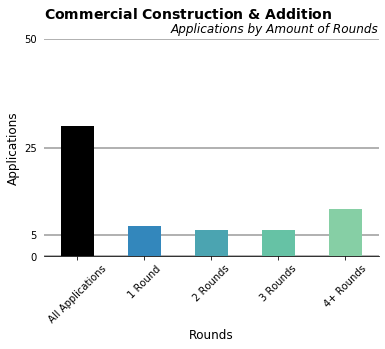

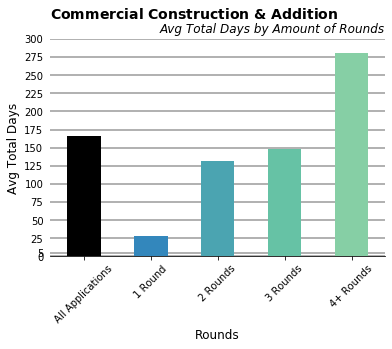

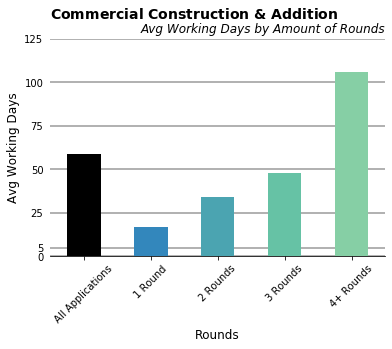

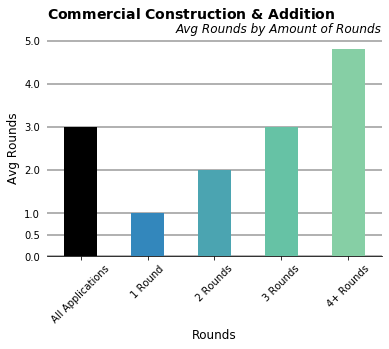

In [111]:
from matplotlib import cm
import matplotlib.pyplot as plt

def get_color(lst, scale = (0,1), type_cmap = 'Spectral', rev=False):
    a,b =  scale
    if type(lst) == list:
        siz = len(list(lst))
    elif type(lst) == int:
        siz = lst
    else:
        siz = int(lst)
    ar = np.linspace(a,b,siz)
    col = list(reversed(cm.get_cmap(type_cmap)(ar)))
    if rev == True:
        col = list(cm.get_cmap(type_cmap)(ar))
    return col

def Dbar(temp, focus='Avg City Business Days', add=False, title='Commercial Alteration', x_label='Total Rounds'):
    if add==False:
        fig, ax = plt.subplots()
    else:
        ax=add

    a,b = cmapset
    siz = len(temp)-1
    ar = np.linspace(a,b,siz)
    col = list(reversed(cm.get_cmap(cmap)(ar)))[1:]

    color = ['black'] + col
    
    field_source = list(temp.index)
    OG_len = len(field_source)

    temp = temp.loc[temp.index!='Over-The-Counter', focus].copy()
    
    labels = list(temp.index)
    
    keep = [field_source.index(l) for l in labels]
    
    rev=False
    if 'Residential' in tit:
        rev=True
    color = get_color(OG_len, scale = cmapset, type_cmap = cmap, rev=rev)
    color = [c for e,c in enumerate(color) if e in keep]
    print(labels)
    if len([l for l in labels if 'All' in l]) > 0:
        color[0] = 'black'
    
    temp.plot(kind='bar', subplots=False, stacked = True, 
              color=color, ax=ax, zorder=5
                               )
    #ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
    #        borderaxespad=0, frameon=False)
    y_label = focus.replace("Avg # of ","")
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if temp.mean() > 5:
        start = 5
        seperation = 25
    elif temp.mean() > 2:
        start = .5
        seperation = 1
    else:    
        start = .2
        seperation = .2
    tick_dist = [start] + list(np.arange(0, temp.max()+seperation, seperation)) 
    
    ax.yaxis.set_ticks(tick_dist)
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, alpha=0.4, color='black', zorder=1)
    ax.yaxis.set_ticks_position('none') 
    
    if title != '':
        ax.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                     loc='left', y=1.065, fontsize=14)
    ax.set_title('{} by Amount of {}'.format(focus, x_label.replace('Total ','')), 
                 loc='right', y=1, style='italic')
    
    #xticks = field_source
    #xticks = [' '.join(t.split()[:int(len(t.split())/2)])+'\n'+' '.join(t.split()[int(len(t.split())/2)]:).split() if len(t)>16
    #          else t
    #          for t in xticks]
    #ax.set_xticklabels(xticks)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
    
    if add==False:
        fig.savefig('{} - {} by {}.png'.format(title, focus.replace('% requiring ',''), x_label.replace('Total ','')), bbox_inches='tight')

for field in list(Records_avg):
    print(field)
    Dbar(Records_avg, focus=field, title='Commercial Construction & Addition', x_label='Rounds')


In [90]:
if 'Planning' in tit:
    Dbar(Records_entitle, focus='% requiring Comm', title='Planning Entitlements')
    Dbar(Records_sub_test, focus='% requiring Comm', title='Design Review')
elif 'Construction' in tit:
    Dbar(Records_const, title='Commercial Construction', x_label='Construction')
    Dbar(Records_const, focus='Avg Rounds', title='Commercial Construction', x_label='Construction')
    

NameError: name 'Records_const' is not defined

### 4.2 Round Pie Chart

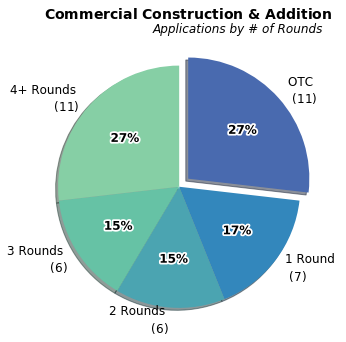

In [114]:
def Qpie(temp, focus= 'Applications', add=False, title='Commercial Alteration', x_label='Rounds', cc=None):
    
    if 'Over-The-Counter' in temp.index:
        temp = temp.rename(index={'Over-The-Counter':'OTC'}).copy()
    if 'DR - Commercial' in temp.index:
        temp = temp.rename(index={'DR - Commercial':'DR - Comm',
                                  'DR - Residential':'DR - Resi'
                                 }).copy()
    
    field_source = list(temp.index)
    OG_len = len(field_source)
    
    temp = temp.loc[~temp.index.str.contains('All')].copy()
    
    
    
    sizes = [p/sum(temp[focus].to_list()) for p in temp[focus].to_list()]
    small_i = [e for e,s in enumerate(sizes) if s < .10]
    if len(small_i) < 2:
        small_i = []
    labels = temp.index.to_list()
    keep = [field_source.index(l) for l in labels]
    labels = [t.replace('DR - ','') for t in temp.index.to_list()]
    small_i_labels = labels.copy()
    fields = labels.copy()
    labels = [str(l) + ' \n $\mathit{ (' + str(a) + ') }$' for l,a in zip(labels, temp[focus].to_list())]
    
    for e,l in enumerate(labels):
        if e in small_i:
            labels[e] = ''
            small_i_labels[e] = str(small_i_labels[e])
            if small_i_labels[e] == "4 Rounds or More":
                small_i_labels[e] = '4+ Rounds'
            siz = int(sizes[e]*100)
            if siz < 1:
                siz = str(round(sizes[e]*100,1))
            small_i_labels[e] = '$\mathbf{ ' + str(siz) + '\% }$ ' + small_i_labels[e]
            
            
        elif e not in small_i:
            small_i_labels[e] = ''
    
    explode = [0] * len(labels)
    explode[0] = 0.1

    if cc == None:
        cc=cmap
    
    rev=False
    if 'Residential' in tit:
        rev=True
    clr = get_color(OG_len, scale = cmapset, type_cmap = cc, rev=rev)
    
    clr = [c for e,c in enumerate(clr) if e in keep]

    if add == False:
        fig, ax = plt.subplots(figsize=(5,5))
    else:
        ax=add
    
    patches, texts, autotexts = ax.pie(sizes, explode=explode, 
                                        labels=labels, autopct='%1.f%%',
            shadow=True, counterclock=False, startangle=90, colors=clr)
    
    #centre_circle = plt.Circle((0,0),0.70,fc='white')
    #fig = plt.gcf()
    #fig.gca().add_artist(centre_circle)
    
    import matplotlib.patheffects as PathEffects
    
    for e,t in enumerate(texts):
        if e in small_i:
            sz = 10
        else:
            sz = 12
        t.set_fontsize(sz)
        
    for e,t in enumerate(autotexts):
        
        if e in small_i:
            sz = (0)
            t.set_fontsize(sz)
        else:
            sz, lw = (12,3.5)
            t.set_fontsize(sz)
            t.set_weight('bold')
            t.set_path_effects([PathEffects.withStroke(linewidth=lw, foreground='w')])
    
    #bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              #bbox=bbox_props, 
              zorder=0, va="center")
    prior_y = 0
    hori = 1
    side = 1
    for i, p in enumerate(patches):
        if small_i_labels[i] != '':
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))

            dif = abs(prior_y - y)
            #print(y, prior_y, dif)

            if dif < .02:
                hori = hori + .1
            if hori > 1.1:
                hori = 1
                side = -1

            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})


            ax.annotate(small_i_labels[i], xy=(x, y), xytext=(side*1*np.sign(x), hori*y),
                        horizontalalignment=horizontalalignment, **kw)
            prior_y = y
        else:
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            prior_y = np.sin(np.deg2rad(ang))
        
        #print(x,y)
        
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    #fig.suptitle('$\mathbf{' + title.replace(' ', ' \\ ') + '}$ by Rounds (#)')
    if add == False:
        ax.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.085, fontsize=14)
    ax.set_title('{} by {}'.format(focus, x_label), 
                 loc='right', y=1.035, style='italic')
    
    
    if add == False:
        fig.savefig('{} - Percentage by {}.png'.format(title, x_label.replace('# of ','')), bbox_inches='tight')     
    
if 'Planning' in tit:
    Qpie(Records_entitle, title='Planning Entitlements', x_label='Entitlement')
    Qpie(Records_sub_test, title='Design Review', x_label='Design Review Type')
#if 'Construction' in tit:
    #Qpie(Records_const, title='Commercial Construction', x_label='Construction Type')
Qpie(Records_avg, title='Commercial Construction & Addition', x_label='# of Rounds')


### 4.3 Quarterly Bar Chart

from matplotlib.ticker import StrMethodFormatter
data = Records.loc[(Records['Count']==1)&(Records['Permit Type'].str.contains('Design Review Commercial')), 'Rounds']
bin_size = 1 
mx = data.max() + bin_size
#upper_bounds = int( 60 * round( mx / 60. ))

#last year
ax = data.hist(bins=[1,2,3,4,5], align='left', grid=False, figsize=(8,4), color='#86bf91', zorder=3, rwidth=0.9)
#data[(data<=mx)].plot.kde(ax=ax, color='#BF868E', secondary_y=True, zorder=4)

"""data2 = Records.loc[(Records['Count']==1)&(Records['Permit Type'].str.contains('Design Review Residential')), 'Rounds']
bin_size = 1 
mx = data.max() + bin_size
#upper_bounds = int( 60 * round( mx / 60. ))

#last year
data2.hist(ax=ax, bins=np.arange(0, mx, bin_size), align='left', grid=False, figsize=(12,8), color='#BF868E', zorder=2, rwidth=0.9)
#data[(data<=mx)].plot.kde(ax=ax, color='#BF868E', secondary_y=True, zorder=4)
"""
plt.tight_layout()

for x in [ax]:

        
    # YLIM
    x.set_ylim((0,22.5))
    
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", 
                  bottom="off", top="off", labelbottom="on", 
                  left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    x.yaxis.set_ticks_position('left')
    x.xaxis.set_ticks_position('bottom')
    #x.xaxis.set_ticks(np.arange(0, CW.loc[(CW['solved']>0), 'Seconds to Complete'].max(), 60))

    # Remove title
    x.set_title("Commercial Design Review")
    
    # XLIM 
    x.set_xlim((0,mx))
    
    # Set x-axis label
    x.set_xlabel("Rounds", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Final Round", labelpad=20, weight='bold', size=12)

    x.axvline(x=data.median(), color='#45734E', zorder=6, ymax=.95, linestyle='--')
    
    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))# Despine

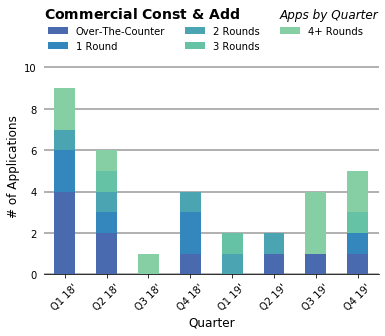

In [115]:
def Qbar(temp, focus='Applications', title='Commercial Alteration', x_label='Quarter'):
    
    field_source = list(Records_avg.index)
    OG_len = len(field_source)
    
    temp = temp.unstack(level=1)[focus].reindex(list(QQ.values()))
    focus_rounds = [tl for tl in list(temp) if tl != 'All Applications']
    temp = temp[focus_rounds].copy()
    if list(temp)[-1] == 'Over-The-Counter':
        new_order = ['Over-The-Counter'] + list(temp)[:-1]
        temp = temp[new_order]
    
    
    
    keep = [field_source.index(l) for l in focus_rounds]
    
    color = get_color(OG_len, scale = cmapset, type_cmap = cmap)
    color = [c for e,c in enumerate(color) if e in keep]
   
    fig, ax = plt.subplots()
    
    temp.plot(kind='bar', subplots=False, stacked = True, 
              color=color, ax=ax, zorder=5
                               )
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
            borderaxespad=0, frameon=False)
    
    y_label = focus.split()
    if len(y_label) == 1:
        y_label = [''] + y_label
    y_label = ' # of '.join(y_label).strip()
    
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    legend_properties = {'weight':'bold'}
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, alpha=0.4, color='black', zorder=1)
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', 
                 loc='left', y=1.15, fontsize=14)
    ax.set_title('{} by {}'.format(focus.replace('Applications','Apps'), x_label), 
                 loc='right', y=1.15, style='italic')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    fig.savefig('{} - Applications by {}.png'.format(title, x_label), bbox_inches='tight') 

Qbar(Records_Q, title='Commercial Const & Add ')


### 4.4 Permit Type Plot

In [116]:
import matplotlib.cm as cm

def SubDbar(temp, y_label='Avg # of City Business Days', cc='Spectral', title='Commercial Alteration', add=False, index_filter=['Over-The-Counter'], x_label='Entitlement'):
    if add == False:
        fig, ax = plt.subplots()
    else:
        ax=add
    
    a,b = cmapset
    siz = len(temp)
    ar = np.linspace(a,b,siz)
    col = list(reversed(cm.get_cmap(cc)(ar)))

    color = col
    
    temp = temp.loc[~temp.index.isin(index_filter), y_label].copy()

    temp.plot(kind='bar', subplots=False, stacked = True, 
              color=color, ax=ax, zorder=5
                               )
    #ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
    #        borderaxespad=0, frameon=False)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_xlabel(x_label, fontsize=10)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if temp.mean() > 5:
        start = 5
        seperation = 20
    elif temp.mean() > 2:
        start = .5
        seperation = 1
    else:    
        start = .2
        seperation = .5
    tick_dist = [start] + list(np.arange(0, temp.max()+seperation, seperation)) 
    ax.yaxis.set_ticks(tick_dist)
    
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, alpha=0.4, color='black', zorder=1)
    ax.yaxis.set_ticks_position('none') 

    ax.set_title('$\mathbf{' + title.replace(' ', ' \\ ') + '}$', loc='left', y=1.065, fontsize=14)
    y_label = y_label.replace("Avg # of ","")
    ax.set_title('{} by {}'.format(y_label, x_label), loc='right', y=1, style='italic')
    
    xlabels = []
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        txt = tick.get_text().replace('Design Review ','DR ')
        if 'All' not in txt:
            txt = txt.replace('DR - ','')
        if txt in entitle.keys():
            txt = entitle[txt]
        txt = r'{}'.format(txt)
        xlabels.append(txt)
    ax.set_xticklabels(xlabels)
    
    if add==False:
        fig.savefig('{} - {} by {}.png'.format(title, y_label.replace('/','ith'), x_label), bbox_inches='tight')
if 'Planning' in tit:    
    SubDbar(Records_entitle, title=tit, y_label='Avg City Business Days', cc='rainbow_r', x_label='Entitlement')
    #Dbar(Records_entitle, title=tit, y_label='Avg Rounds', cc='rainbow_r', x_label='Entitlement')
    SubDbar(Records_entitle, title=tit, y_label='% requiring Comm', cc='rainbow_r', x_label='Entitlement')

    SubDbar(Records_drdr, title='Planning Applications - Design Review', y_label='Avg City Business Days', cc='inferno_r', x_label='DR Land Use')
    #Dbar(Records_drdr, title='Planning Applications - Design Review', y_label='Avg Rounds', cc='inferno_r', x_label='DR Land Use')
    SubDbar(Records_drdr, title='Planning Applications - Design Review', y_label='% requiring Comm', cc='inferno_r', x_label='DR Land Use')
    Qpie(Records_drdr, title='Planning Applications - Design Review', x_label='DR Land Use', cc='inferno_r')

if 'Planning' in tit: 
    col, lab = ('Set2', 'Design Review')
    Dbar(Records_sub_test[Records_sub_test.index!='All Applications'], title=tit, y_label='Avg City Business Days', cc=col, x_label=lab)
    #Dbar(Records_sub_test, title=tit, y_label='Avg Rounds', cc=col, x_label=lab)
    Dbar(Records_sub_test[Records_sub_test.index!='All Applications'], title=tit, y_label='% requiring Comm', cc=col, x_label=lab)
    Qpie(Records_sub_test[Records_sub_test.index!='All Applications'], title='Planning Applications - Design Review', x_label=lab, cc=col)

### 4.5 Create PDF

In [118]:
t = tit

['All Applications', '1 Round', '2 Rounds', '3 Rounds', '4+ Rounds']


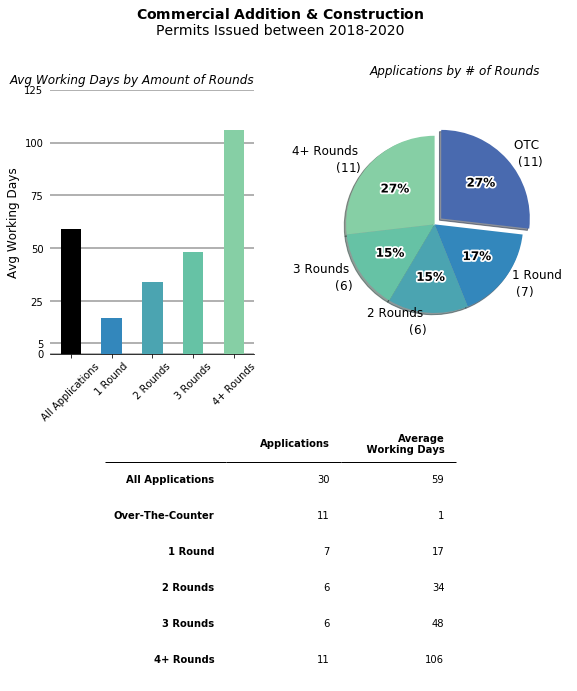

In [119]:
tit = t

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.patches as patches

focus_avg = Records_avg.copy()
if tit == 'Planning Applications':
    tit = 'Design Review'
    focus_avg = Records_sub_test.copy()
    table = Records_sub_test[[
        'Applications', 'Avg City Business Days', '% requiring Comm'
    ]]
else:
    table = Records_avg[[
    'Applications', 'Avg City Business Days'
    ]]

with PdfPages('{}.pdf'.format(tit)) as pdf:
    fig = plt.figure(figsize=(8.5,11))
    buff=.125
    
    fig.suptitle(r"$\bf{}$".format(tit.replace(' ','\ ')) + 
                 "\nPermits Issued between 2018-2020", 
                 fontproperties=FontProperties(size=14))
    
    n=0
    
    n += 1
    ax = fig.add_subplot(2,2,n)
    plt.subplots_adjust(left=0+buff, bottom=0+buff, right=1-buff, top=1-buff, wspace=0+2*buff, hspace=0+2*buff)
    Dbar(focus_avg, focus='Avg City Business Days', add=ax, title='', x_label='Rounds')    
    ax.set_xlabel('')
    
    n += 1
    ax = fig.add_subplot(2,2,n)
    #plt.subplots_adjust(left=0+buff, bottom=0+buff, right=1-buff, top=1-buff, wspace=0+2*buff, hspace=0+2*buff)
    Qpie(focus_avg.rename(index={
        '2-3 Rounds':'2-3 Rds'
    }), title=tit, add=ax, x_label='# of Rounds')
    
    pos1 = ax.get_position()
    pos2 = [pos1.x0 + .05, pos1.y0,  pos1.width , pos1.height ] 
    ax.set_position(pos2)
    
    n += 1
    ax = fig.add_subplot(2,1,2)
    #plt.subplots_adjust(left=0+buff, bottom=0+buff, right=1-buff, top=1-buff, wspace=0+2*buff, hspace=0+2*buff)
    ax.axis('off')
    
    
    labels = ["{}\n{}".format(c[:c.find(' ', 3, len(c))],
                                c[c.find(' ', 3, len(c)):]).replace('Avg', 'Average').replace('Comm','a Commission') if ' ' in c
              else c
              for c in list(table)]
    Table = ax.table(cellText=table.values.astype(int),
                        rowLabels=table.index,
                        colLabels=labels,
                        loc='center',
                        clip_on=True
                    )
    
    Table.scale(1,3)
    Table.set_fontsize(12)
    
    for key, cell in Table.get_celld().items():
        row, col = key
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            cell._loc = 'right'
        if row == 1:
            cell.visible_edges='T'
        else:
            cell.visible_edges=''
        cell.set_width(.5)
        if col >= 0:
            cell.set_width(.25)
        
    pos1 = ax.get_position()
    pos2 = [pos1.x0 + .05*len(list(table)), pos1.y0,  pos1.width , pos1.height ] 
    ax.set_position(pos2)
       
    pdf.savefig(fig, pad_inches = 1)

## 5. To Excel

### 5.1 Merged Summary Fields

In [120]:
"""if 'Planning' in tit:
    DR = Records_DR

    DR.columns = DR.columns.str.replace('Avg # of ', '').str.strip()

    d = {}

    d[''] = DR[['# of Applications']]

    d['Average'] = DR[['City Business Days','Rounds','Commissions']]

    DRs = pd.concat(d, axis=1)
    DRs['Average'].columns = DRs['Average'].columns.to_series().apply(lambda x: x)
    DRs"""

"if 'Planning' in tit:\n    DR = Records_DR\n\n    DR.columns = DR.columns.str.replace('Avg # of ', '').str.strip()\n\n    d = {}\n\n    d[''] = DR[['# of Applications']]\n\n    d['Average'] = DR[['Working Days','Rounds','Commissions']]\n\n    DRs = pd.concat(d, axis=1)\n    DRs['Average'].columns = DRs['Average'].columns.to_series().apply(lambda x: x)\n    DRs"

### 5.2 Export Excel Sheets

In [123]:
import datetime

def colnum_string(n):
    string = ""
    n = n + 1
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string

def rng_create(A, one, B, two):
    return str(colnum_string(A)) + str(one) + ":" + str(colnum_string(B)) + str(two)

def get_col_widths(dataframe):
    # First we find the maximum length of the index column   
    idx_max = max([len(str(s)) for s in dataframe.index.values] + [len(str(dataframe.index.name))])
    # Then, we concatenate this to the max of the lengths of column name and its values for each column, left to right
    return [idx_max] + [max([len(str(s)) for s in dataframe[col].values] + [len(col)]) for col in dataframe.columns]

def normalize_types(lyr):
        str_list = list(lyr.select_dtypes(include=['datetime','period[Q-DEC]','O']))
        convert_dict = {s:str for s in str_list}
        no_str = [l for l in list(lyr) if l not in str_list]
        no_dict = lyr[no_str].dtypes.to_dict()
        convert_dict.update(no_dict)
        return lyr.astype(convert_dict)

new_path = 'BlueTest_{}_{}.xlsx'.format(dept, tit.replace(' ',''))

import xlsxwriter as xlsx
wrkbk = xlsx.Workbook(new_path)
if len(tit)>32:
    tit = 'Comm Add & Const'
for OG, name in [(Records.fillna(value=''),tit), 
                 #(Records.loc[(Records['Permit Type'].str.contains('Design Review'))&(Records['Count']==1)], 'DR Applications'), 
                 (Records_avg, 'Averages'), 
                 (Records_Q, 'Quarterly Averages'), 
                 #(Records_const, 'Construction')
                 #(Records_entitle, 'Entitlements'), (Records_sub_test, 'Design Review')
                ]:
    worksheet = wrkbk.add_worksheet(name)
    
    lyr = OG.copy()
    
    lyr = normalize_types(lyr)
    
    lyr = lyr.fillna(value='')
    
    header = np.array([[lyr.index.name] + list(lyr)])
    data = lyr.reset_index().to_numpy()
    if data.shape[1] != header.shape[1]:        
        dif = data.shape[1] - header.shape[1]
        fix_head = [lyr.index.name] + list(lyr)
        for r in range(dif):
            fix_head = [' '] + fix_head
        header = np.array([fix_head])
    table = np.vstack((header,data))
    numRows,numColumns = table.shape
    
    idx = [0]
    if type(lyr.index) == pd.MultiIndex:
        idx.append(1)
        table[0,0:2] = list(lyr.index.names)
    else:
        table[0,0:1] = list(lyr.index.names)

    for c in range(numColumns):
        try:
            for r in range(numRows):
                format_dict = {'font_name':'Arial'}

                # TOP
                if (r == 0) & (c not in idx):
                    format_dict['bottom'] = 2
                    format_dict['bold'] = True
                    format_dict['text_wrap'] = True
                # INDEX NAME
                if (r == 0) & (c in idx):
                    format_dict['italic'] = True
                # RIGHT
                elif (r != 0) & (c == range(numColumns)[-1]):
                    format_dict['right'] = 2
                    if (r == range(numRows)[-1]):
                        format_dict['bottom'] = 2
                # LEFT
                elif (r != 0) & (c in idx):
                    format_dict['bold'] = True
                    if (1 not in idx)or(c == 1):
                        format_dict['right'] = 2
                # BOTTOM
                elif (r == range(numRows)[-1]) & (c not in idx):
                    format_dict['bottom'] = 2
                    if (c == range(numColumns)[-1]):
                        format_dict['right'] = 2
                item = table[r][c]
                if item == np.nan:
                    item = ''

                cell_format = wrkbk.add_format(format_dict)
                worksheet.write(r, c, item, cell_format)
            if c not in idx:
                worksheet.set_column(c, c, 10)
            else:
                worksheet.set_column(c, c, len(max(table[:,c], key=len))+1)
        except:
            print(table[r,c])
            
wrkbk.close()


In [40]:
#Records = get_counts(Formatted_Permits)
#Formatted_Permits = get_counts(Formatted_Permits)
#Formatted_Permits = Formatted_Permits[(Formatted_Permits['Final Date'].dt.to_period('Q') > less)&(Formatted_Permits['Final Date'].dt.to_period('Q') < great)]
#Formatted_Permits['Reviews'] = Formatted_Permits.index.map(get_reviews(path, let=True)).fillna(value=0)

#file_name = r'BlueTest_Building_Const.csv'
#path = os.path.join(os.getcwd(), file_name)
#BCo = prepare_times(path, prep=True)
#BCo = get_counts(BCo)
#BCo = join_cates(BCo, path)
#BCo['Reviews'] = BCo.index.map(get_reviews(path, let=True)).fillna(value=0)

#file_name = r'BlueTest_Building_B_SDP.csv'
#path = os.path.join(os.getcwd(), file_name)
#SDP = prepare_times(path, prep=True, sdp=True)
#SDP = get_counts(SDP)

#SDP = join_cates(SDP, path)
#SDP['Reviews'] = SDP.index.map(get_reviews(path, let=True)).fillna(value=0)

#pd.DataFrame(ts)